## Data Exploration

This notebook was used to explore the data, build initial features and do some machine learning tests.

Machine learning tested:
- Randon Forest
- Catboost
- XGBoost (the best)

The final model is on: final_model_sumission.ipynb

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn import metrics
from math import sqrt
from sklearn.model_selection import cross_val_predict


import warnings
warnings.filterwarnings('ignore')

I wrote a class data_preparation to all data pré processing and feature engineering.

In [5]:
import data_preparation_v5 as dp

df_train = dp.data_prep('GBS Building Attendance  - Train.csv')

Starting....
Running....
Finished....


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172546 entries, 0 to 172545
Data columns (total 41 columns):
date_hour                 172546 non-null datetime64[ns]
building_floor            172546 non-null object
number_of_metro_1         172546 non-null float64
number_of_rer_a           172546 non-null float64
temp_c                    172546 non-null float64
high_cloud_cover_per      172546 non-null float64
medium_cloud_cover_per    172546 non-null float64
low_cloud_cover_per       172546 non-null float64
precipitation_mm          172546 non-null float64
sunshine_duration_h       172546 non-null float64
is_a_strike_ratp_day      172546 non-null int64
is_a_strike_sncf_day      172546 non-null int64
floor_capacity            172546 non-null float64
attendance                172546 non-null float64
hour                      172546 non-null int64
date                      172546 non-null object
year                      172546 non-null int64
month                     172546 non-null 

Analysing the Attendance impact in the predictor features 

Attendance per hour

<BarContainer object of 172546 artists>

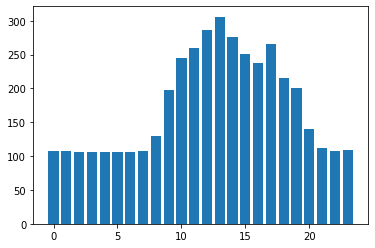

In [4]:
plt.bar(x=df_train['hour'], height=df_train['attendance'])

<BarContainer object of 172546 artists>

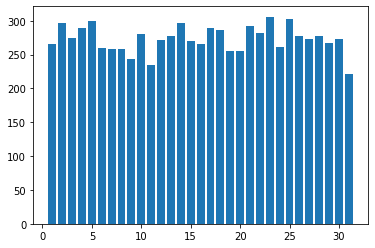

In [5]:
plt.bar(x=df_train['day'], height=df_train['attendance'])

<BarContainer object of 172546 artists>

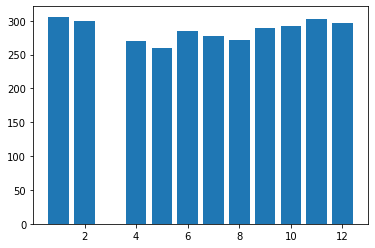

In [6]:
plt.bar(x=df_train['month'], height=df_train['attendance'])

Attendance per Weekday, Business Day (holiday and weekends) and Holiday

<BarContainer object of 172546 artists>

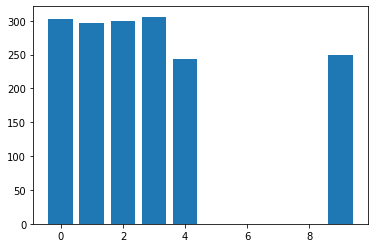

In [7]:
plt.bar(x=df_train['weekday'], height=df_train['attendance'])

<BarContainer object of 172546 artists>

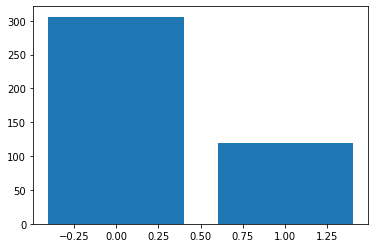

In [8]:
plt.bar(x=df_train['busday'], height=df_train['attendance'])

<BarContainer object of 172546 artists>

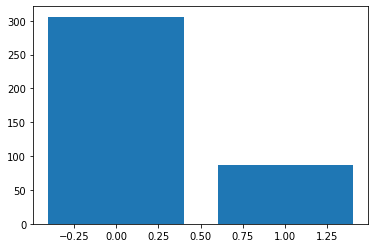

In [9]:
plt.bar(x=df_train['holiday'], height=df_train['attendance'])

Analysing Attendance versus climate conditions

<BarContainer object of 172546 artists>

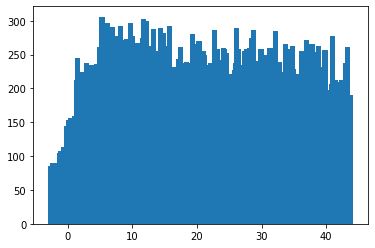

In [10]:
plt.bar(x=df_train['temp_c'], height=df_train['attendance'])

<BarContainer object of 172546 artists>

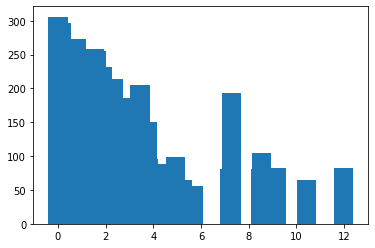

In [11]:
plt.bar(x=df_train['precipitation_mm'], height=df_train['attendance'])

Analysing Attendance versus strikes

<BarContainer object of 172546 artists>

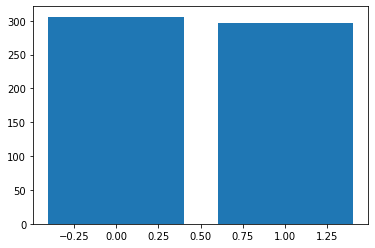

In [3]:
plt.bar(x=df_train['is_a_strike_ratp_day'], height=df_train['attendance'])

<BarContainer object of 172546 artists>

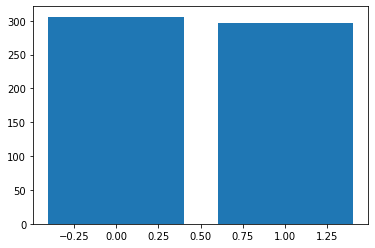

In [4]:
plt.bar(x=df_train['is_a_strike_sncf_day'], height=df_train['attendance'])

Ploting the attendance distribuction 

{'whiskers': [<matplotlib.lines.Line2D at 0x1932018bb48>,
 'caps': [<matplotlib.lines.Line2D at 0x1932019db88>,
 'boxes': [<matplotlib.lines.Line2D at 0x1932015edc8>],
 'medians': [<matplotlib.lines.Line2D at 0x193201d8408>],
 'fliers': [<matplotlib.lines.Line2D at 0x193201e00c8>],
 'means': []}

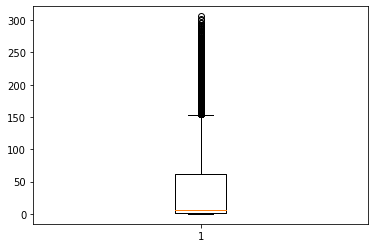

In [5]:
plt.boxplot(x=df_train['attendance'])

This was the main plot for explore the features in a time line spliting by floor. 

I explored each floor in that way. This visualizations was the best way to understand the patterns.

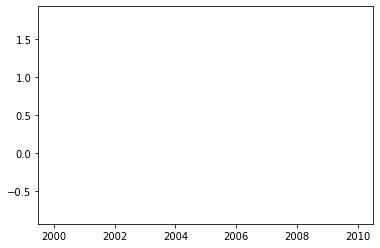

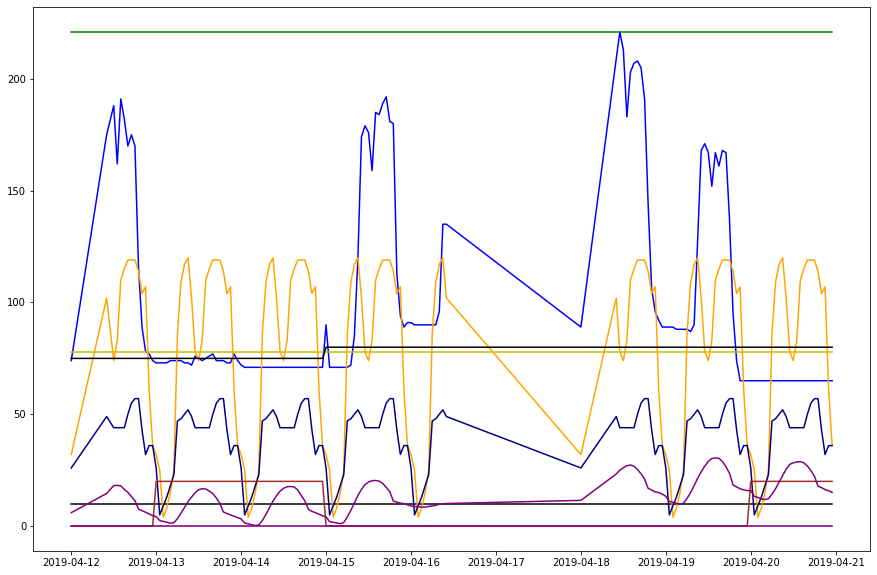

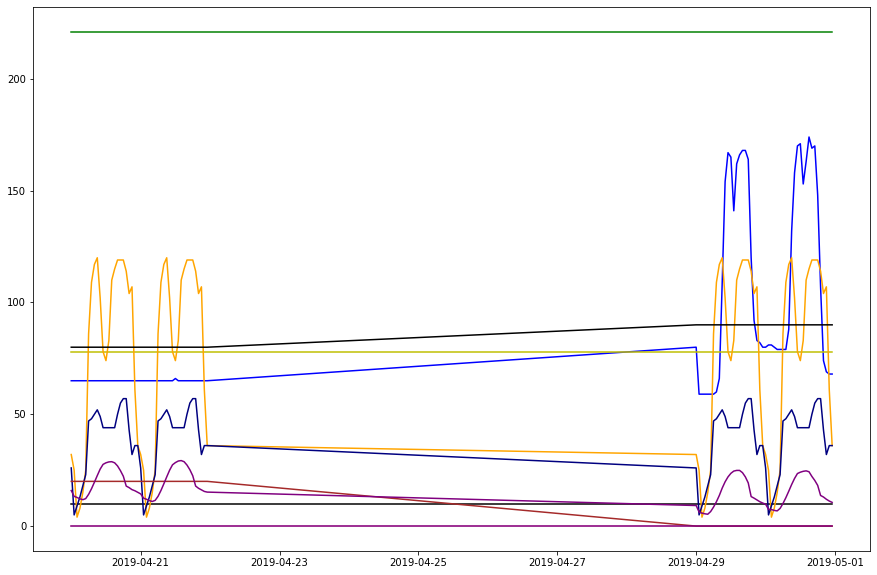

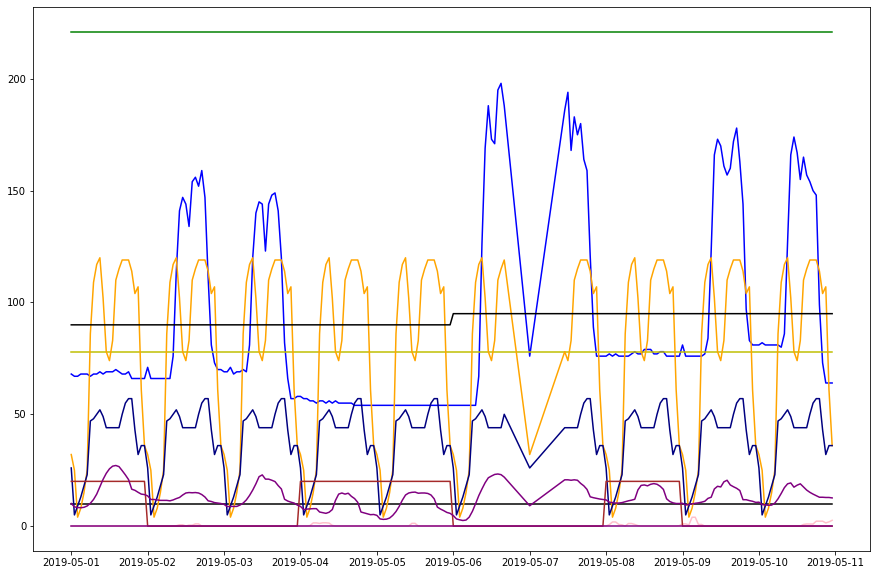

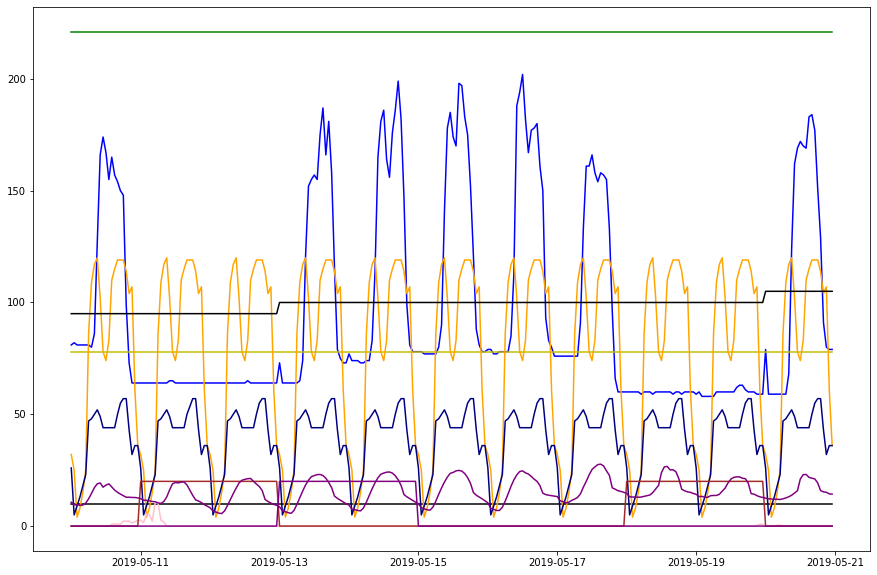

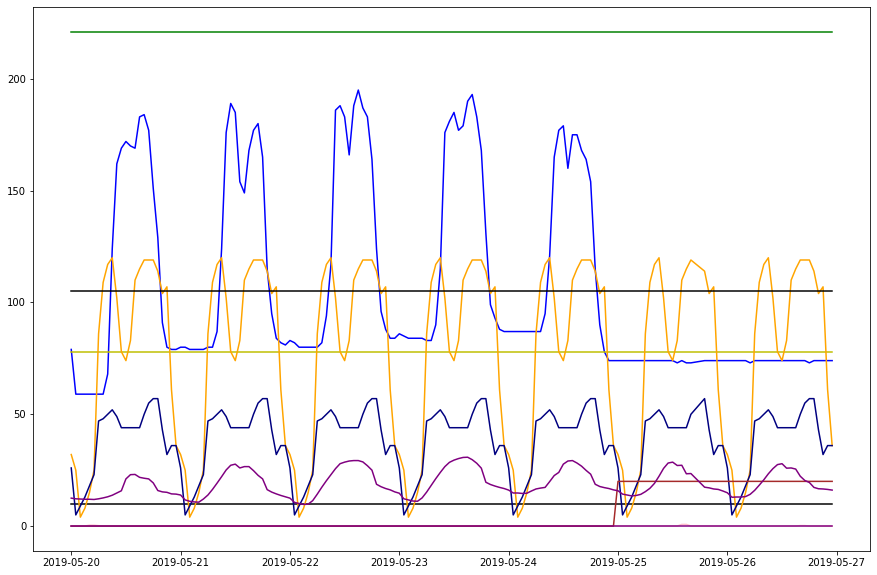

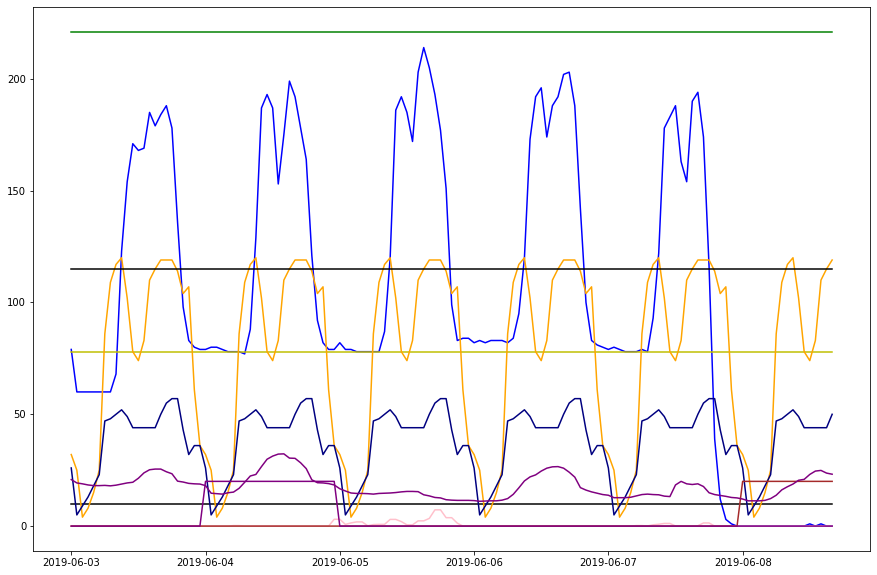

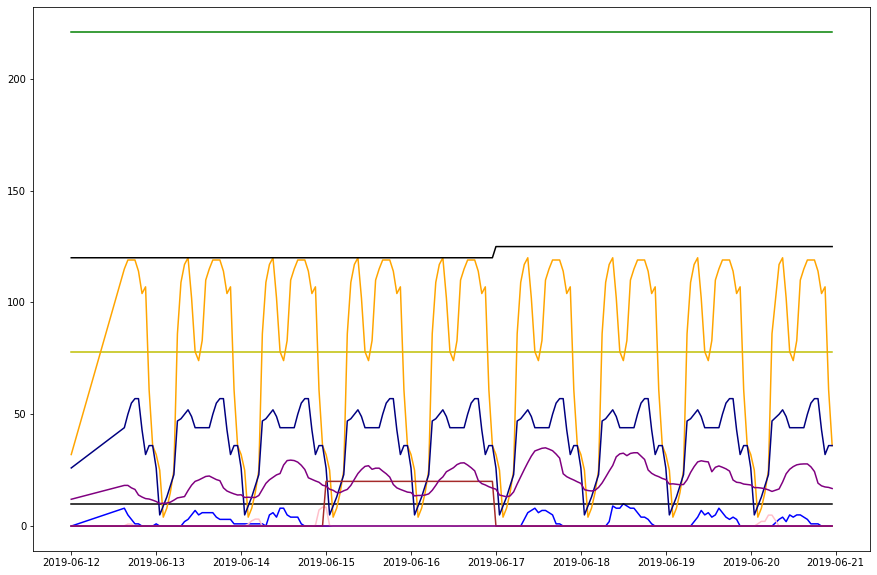

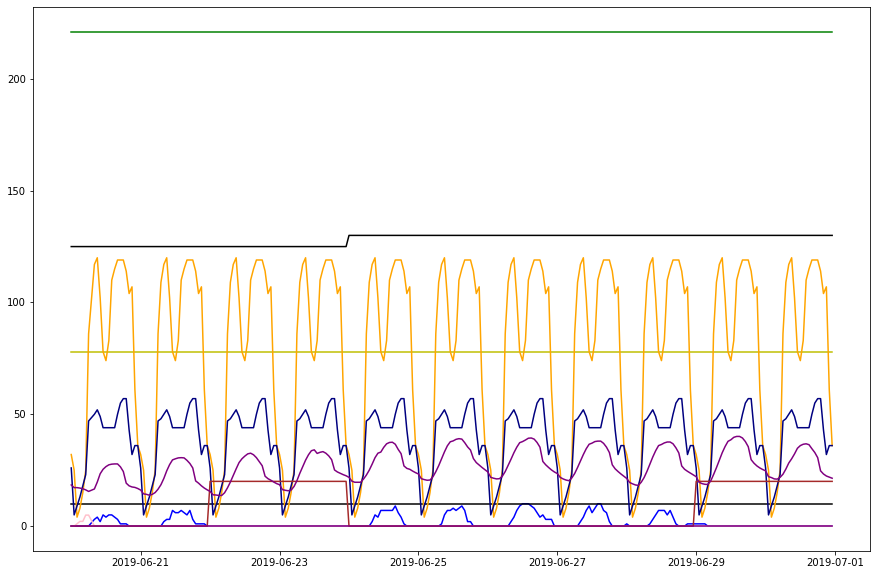

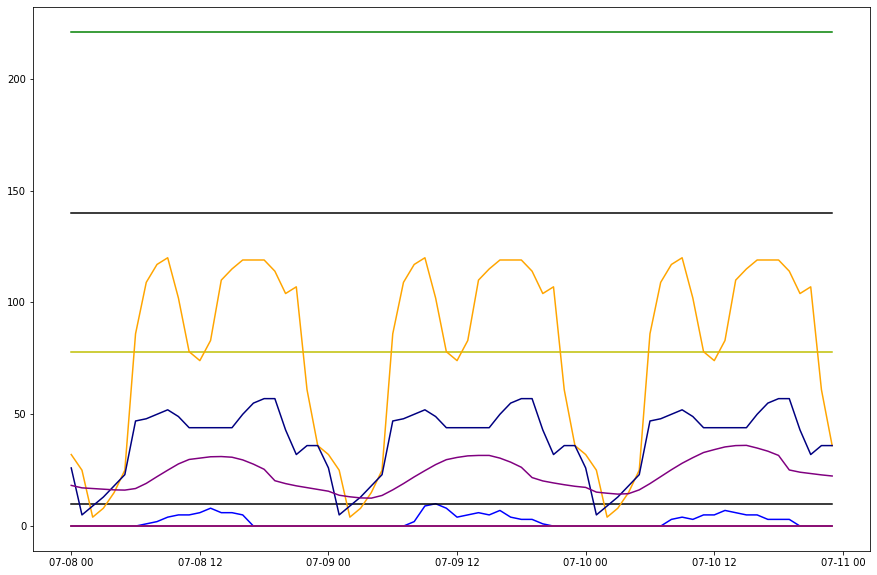

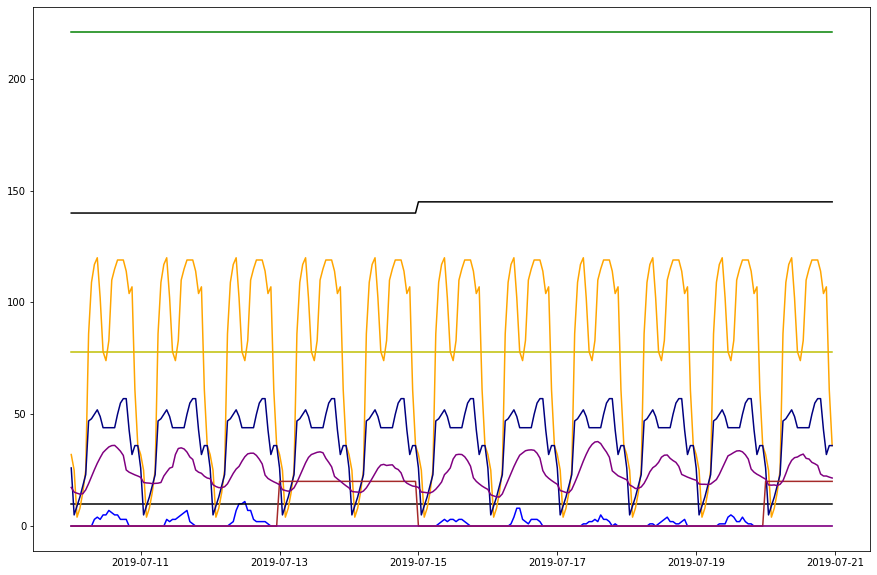

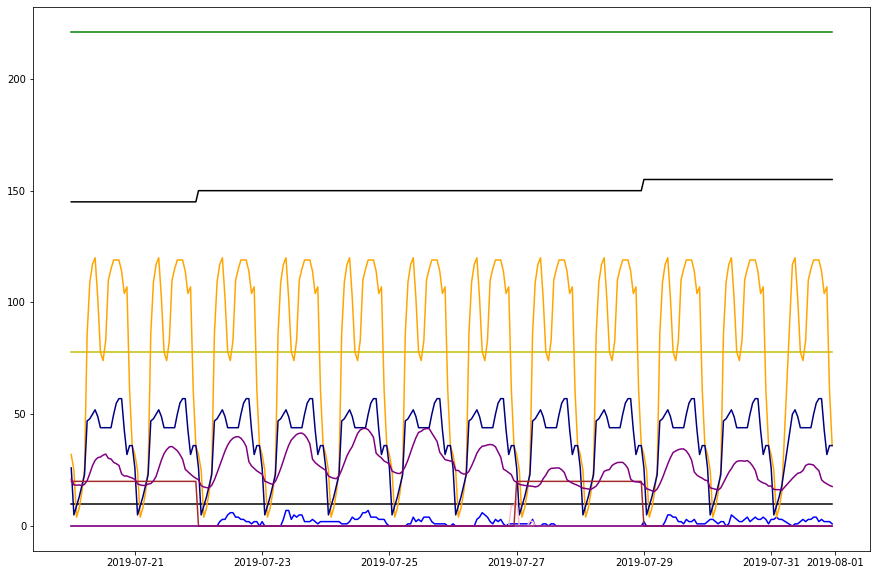

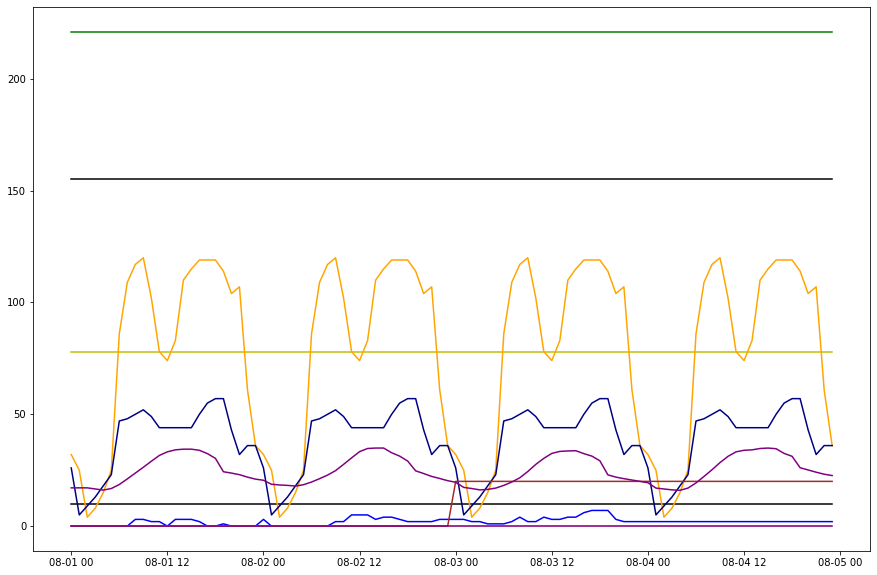

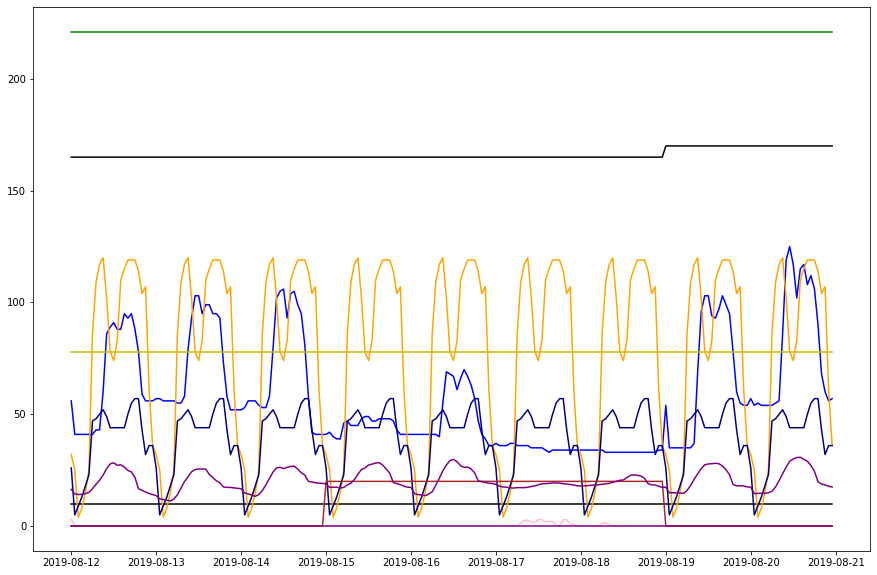

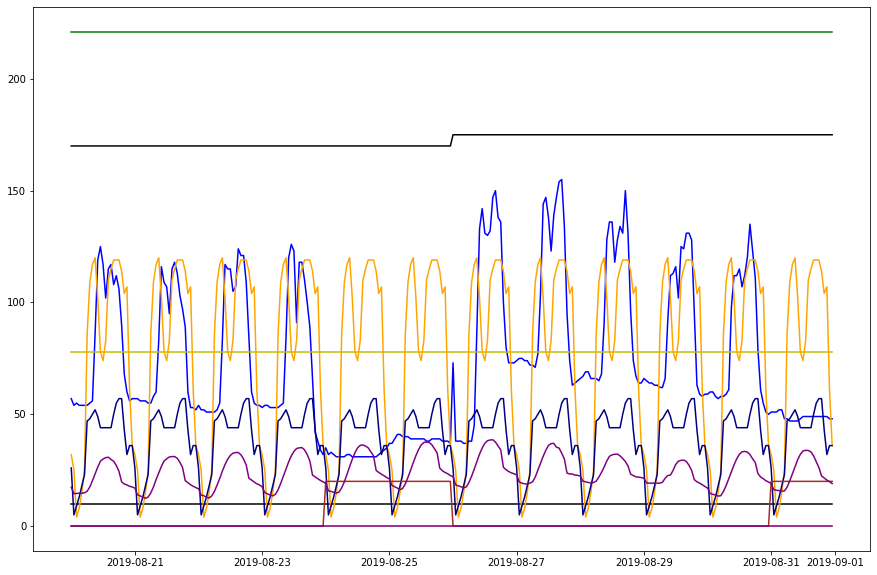

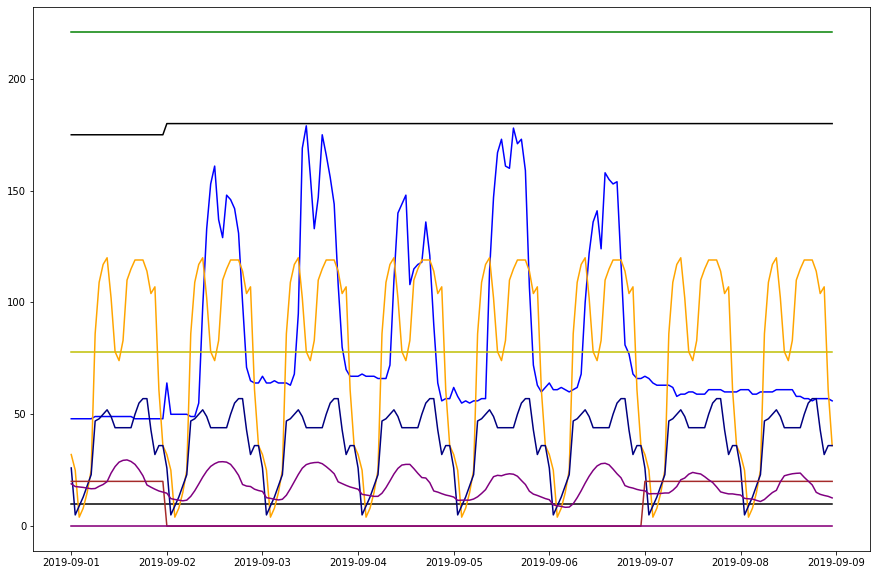

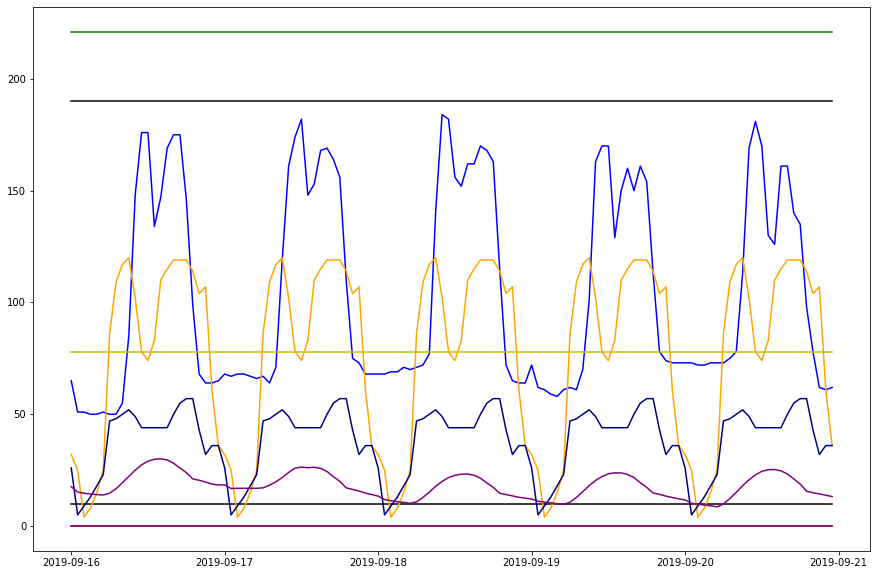

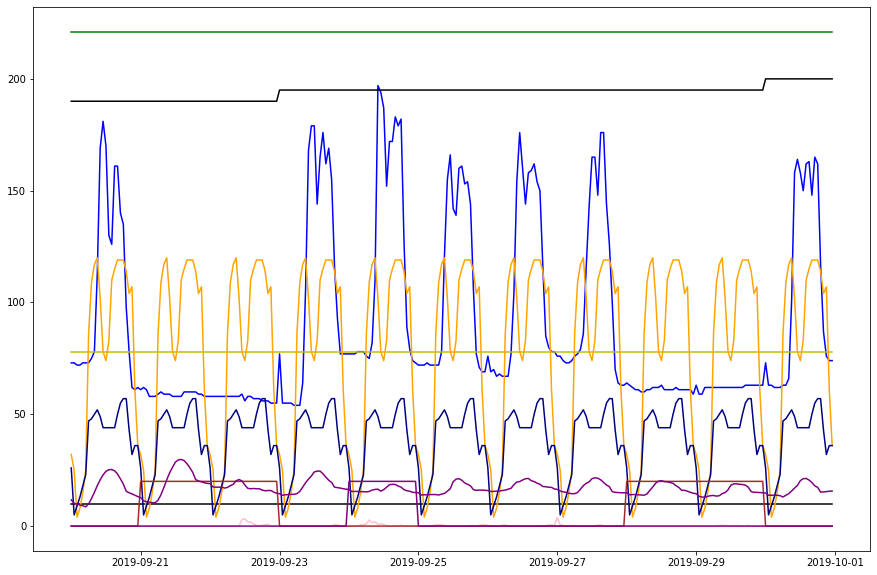

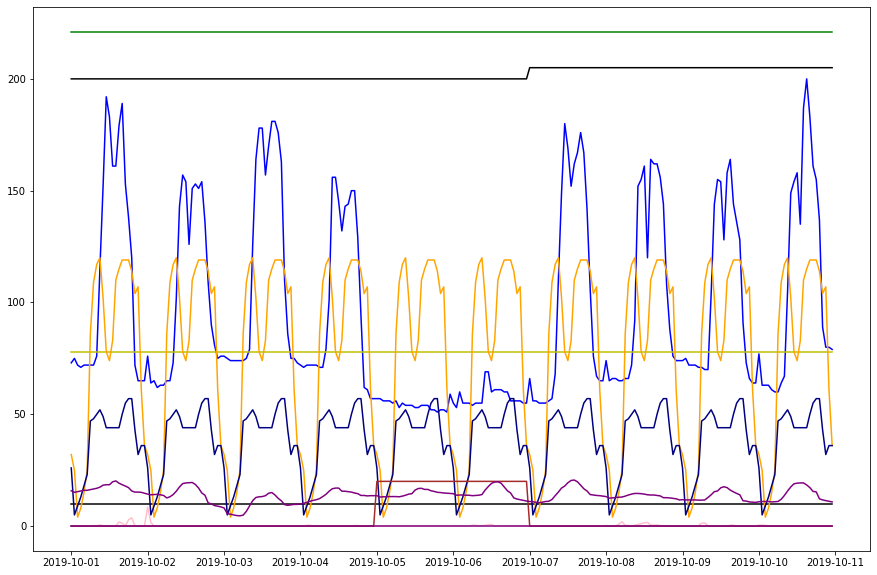

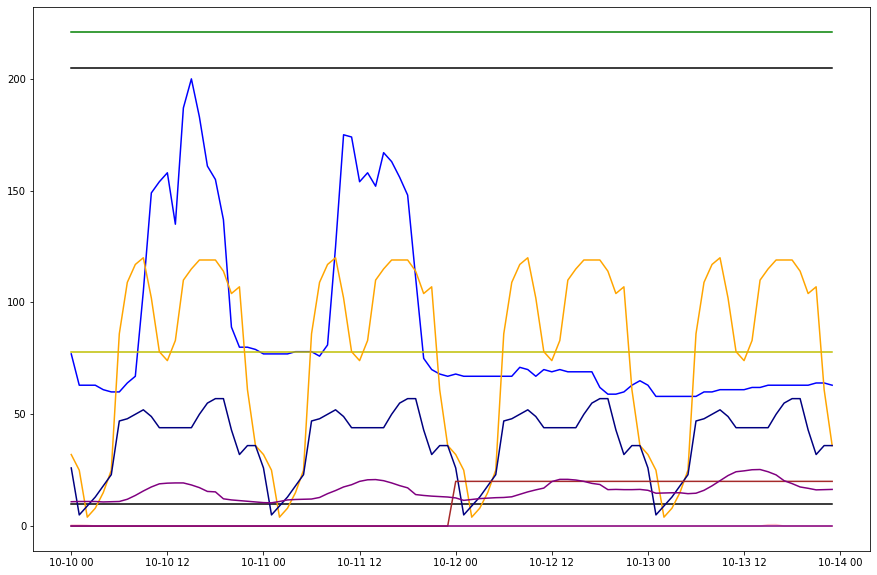

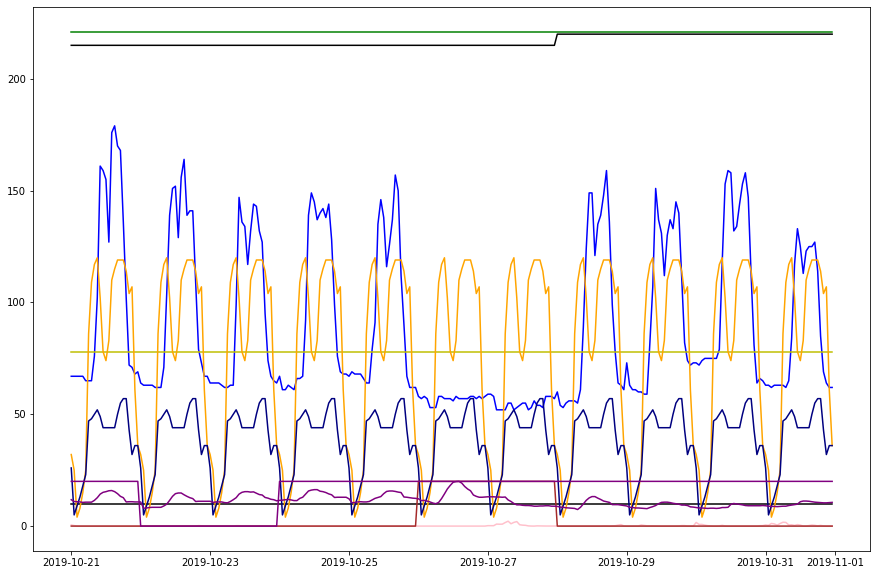

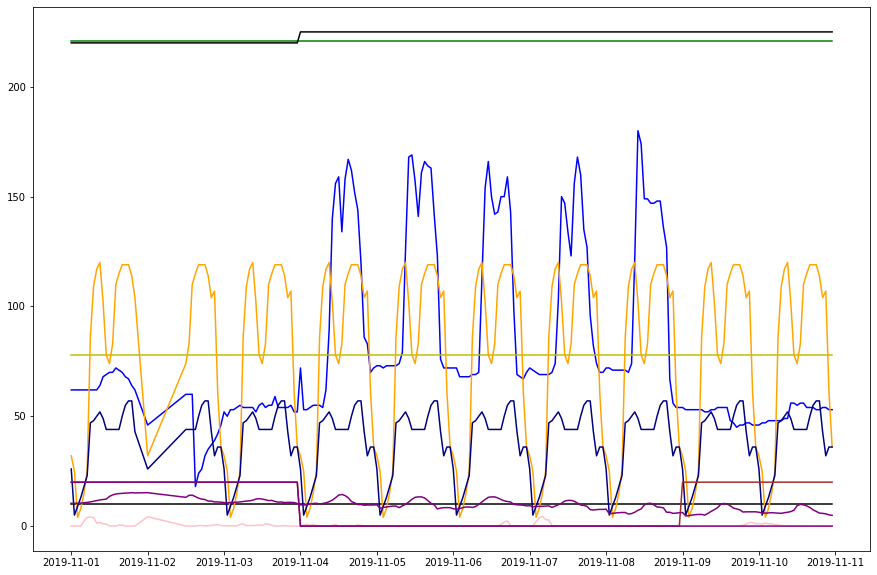

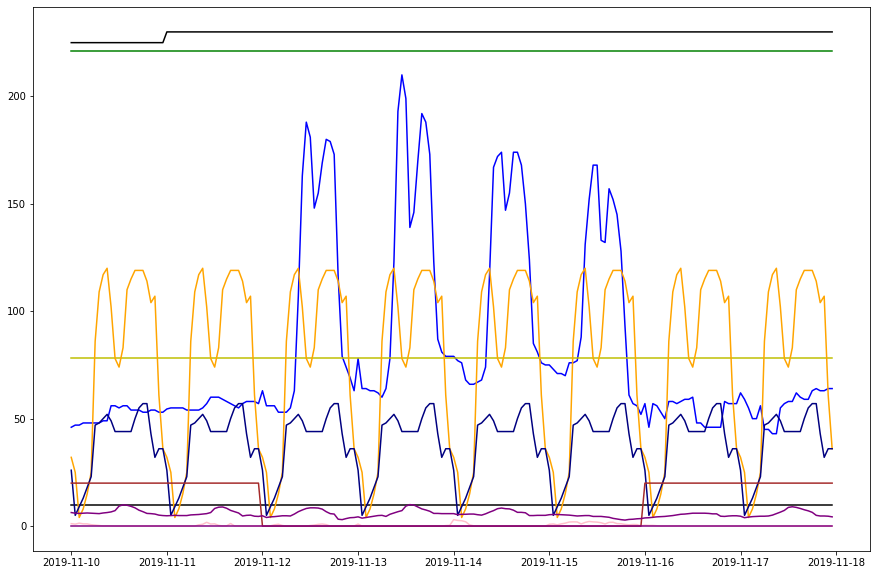

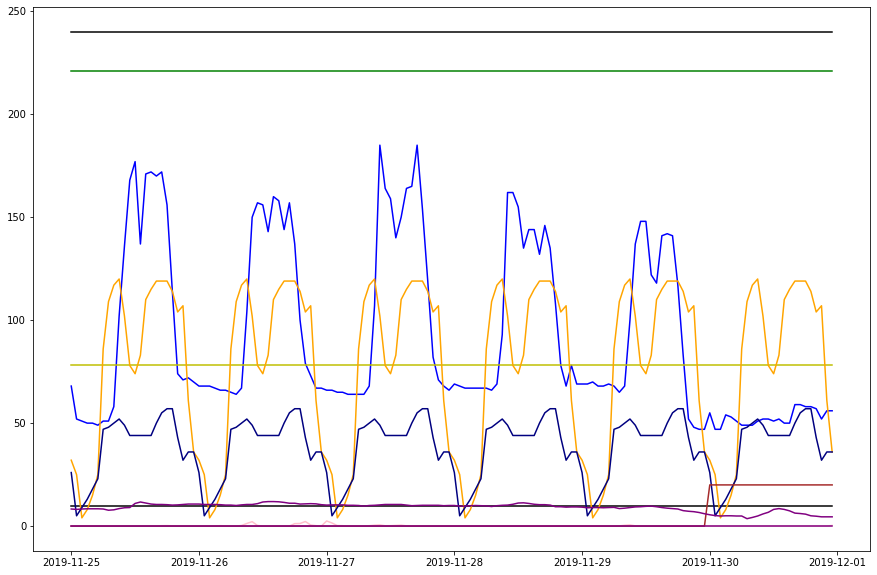

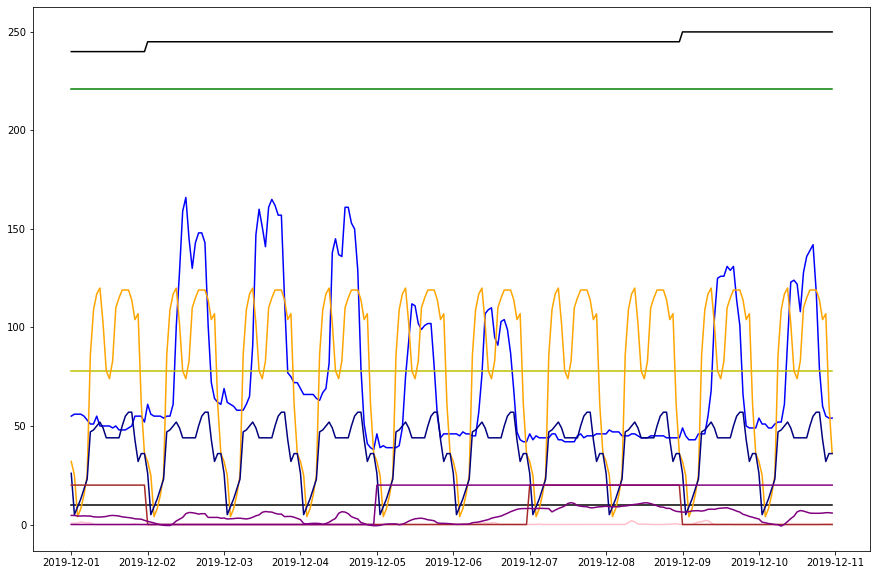

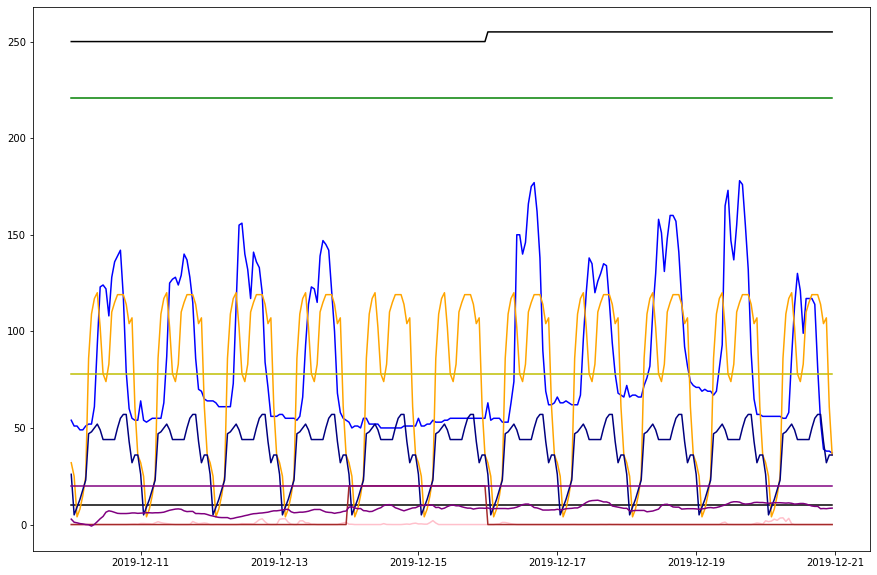

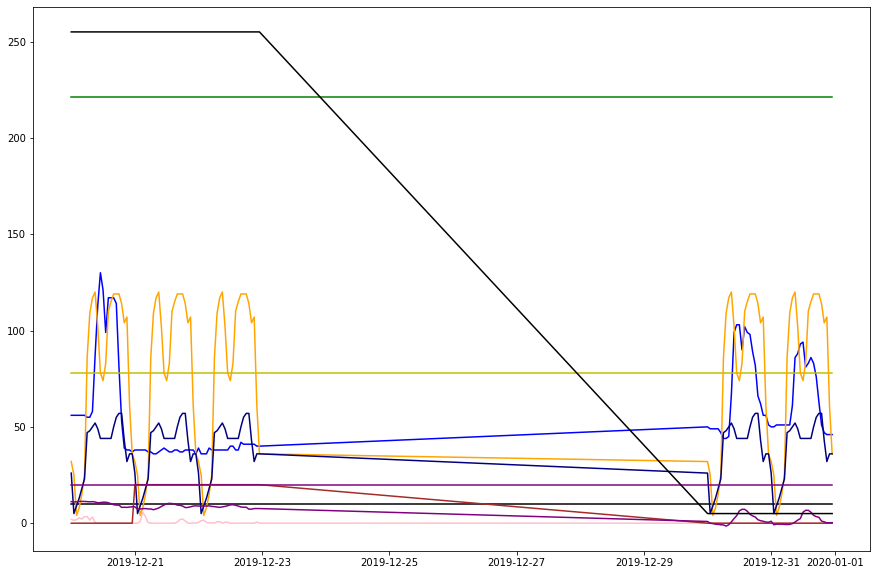

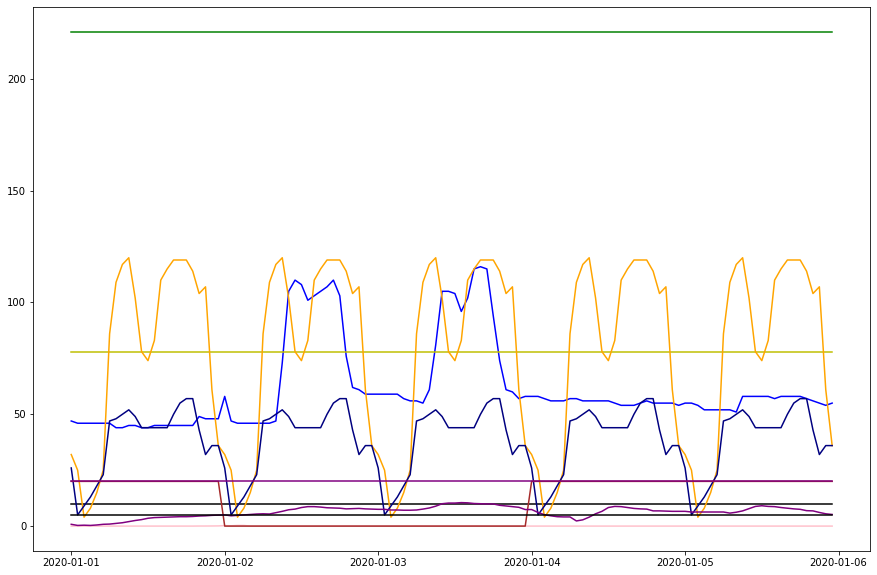

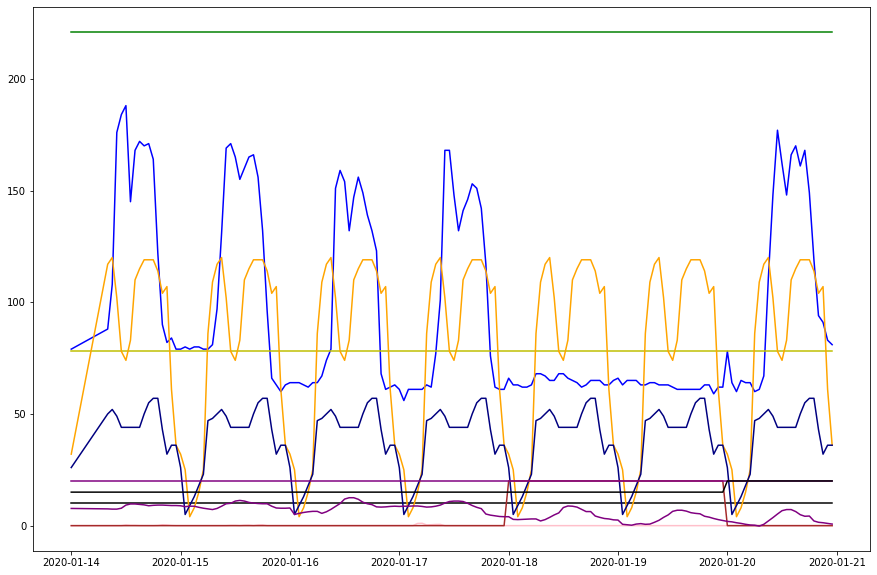

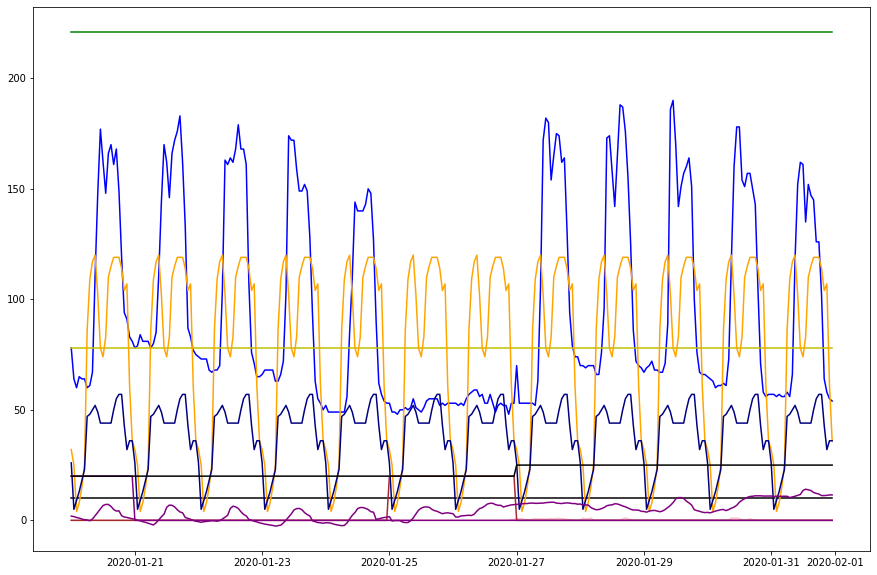

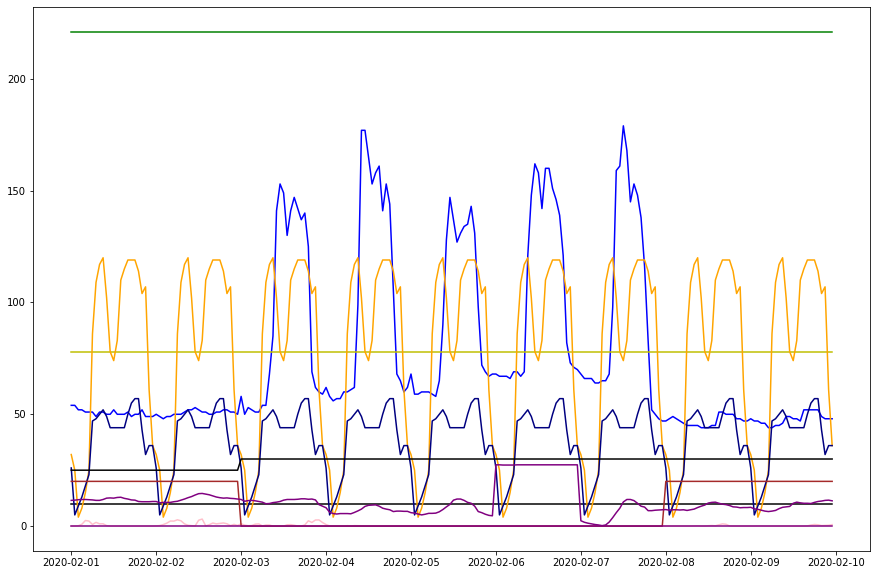

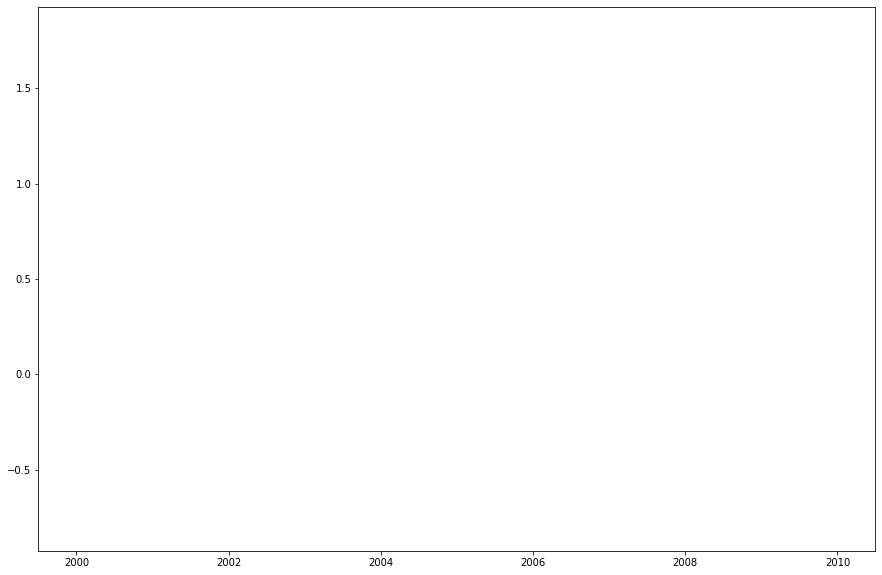

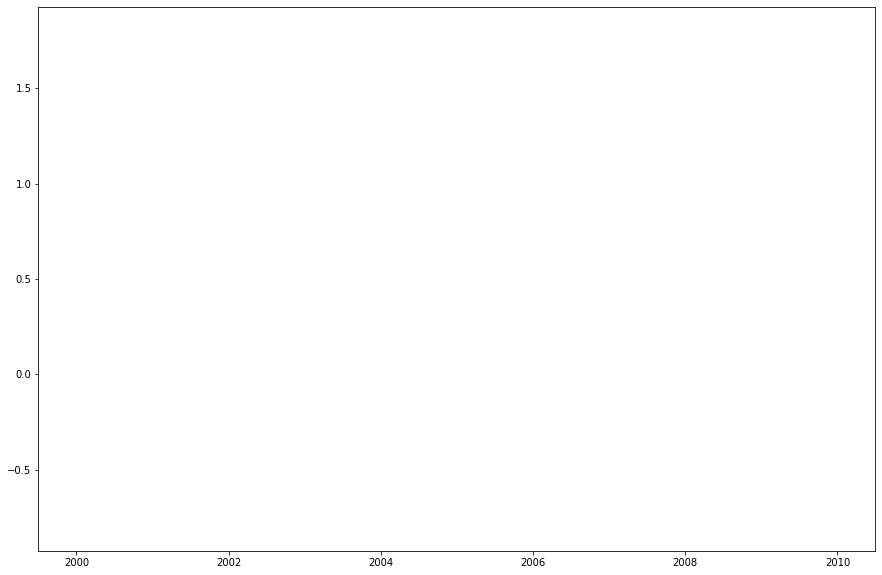

In [6]:


dff = df_train[(df_train['building_floor'] == 'T104')]

# this features have short values, multiplying to see the features in the plot
dff['busday'] = dff['busday'] * 20
dff['strike_day'] = dff['strike_day'] * 20
dff['week_number'] = dff['week_number'] * 5
dff['precipitation'] = dff['precipitation_mm'] * 20

dff['month_str'] = dff['month'].apply(lambda x: '{:02d}'.format(x))
dff['yearmonth'] = dff['year'].astype(str) + dff['month_str']

ym = dff['yearmonth'].unique()


for m in ym:
    i = 0
    f = 10
    dfym = dff[dff['yearmonth'] == m]
    
    while(f <= 32):
        df1 = dfym[(dfym['day'] >= i) & (dfym['day'] <= f)]
        figure = plt.figure()
        plt.plot(df1['date_hour'], df1['attendance'], color='b')
        plt.plot(df1['date_hour'], df1['floor_capacity'], color='g')
        plt.plot(df1['date_hour'], df1['meeting_room_capacity'], color='y')
        plt.plot(df1['date_hour'], df1['meeting_room_number'], color='black')
        plt.plot(df1['date_hour'], df1['number_of_metro_1'], color='orange')
        plt.plot(df1['date_hour'], df1['number_of_rer_a'], color='navy')
        plt.plot(df1['date_hour'], df1['precipitation_mm'], color='pink')
        plt.plot(df1['date_hour'], df1['busday'], color='brown')
        plt.plot(df1['date_hour'], df1['strike_day'], color='purple')
        plt.plot(df1['date_hour'], df1['temp_c'], color='purple')
        plt.plot(df1['date_hour'], df1['week_number'], color='black')
        
        plt.rcParams['figure.figsize'] = (15,10)
        plt.show()
        
        i = f
        f = f + 10
        if f == 30:
            f = 32

Machine Learning Exploration

Some history of tests with differents features

In [3]:


#x = df_train[['temp_c', 'precipitation_mm', 'sunshine_duration_h', 'floor_capacity', 'hour', 'weekday', 'holiday']]
#RMSE: 21.45769838903564 - Randon Forest
#x = df_train[['temp_c', 'precipitation_mm', 'sunshine_duration_h', 'floor_capacity', 'hour', 'weekday', 'holiday', 'busday']]
#RMSE: 21.025594627671797 - Randon Forest
#x = df_train[['temp_c', 'precipitation_mm', 'sunshine_duration_h', 'floor_capacity', 'hour', 'weekday', 'holiday', 'busday', 'is_a_strike_ratp_day', 'is_a_strike_sncf_day' ]]
#RMSE: 20.928479977959125 - Randon Forest
#x = df_train[['temp_c', 'precipitation_mm', 'sunshine_duration_h', 'floor_capacity', 'hour', 'weekday', 'holiday', 'busday', 'is_a_strike_ratp_day', 'is_a_strike_sncf_day', 'meeting_room_number', 'meeting_room_capacity' ]]
#RMSE: 19.640385922074824 - Randon Forest
#x = df_train[['temp_c', 'precipitation_mm', 'sunshine_duration_h', 'floor_capacity', 'hour', 'weekday', 'holiday', 'busday', 'is_a_strike_ratp_day', 'is_a_strike_sncf_day', 'meeting_room_number', 'meeting_room_capacity', 'fact_building_floor' ]]
#RMSE: 19.605925395206466 - Randon Forest
#RMSE: 15.919916916500792 - Gradient Boosting

#x = df_train[['temp_c', 'precipitation_mm', 'sunshine_duration_h', 'floor_capacity', 'hour', 'weekday', 'holiday', 'busday', 'is_a_strike_ratp_day', 'is_a_strike_sncf_day', 'meeting_room_number', 'meeting_room_capacity', 'fact_building_floor', 'number_of_metro_1', 'number_of_rer_a' ]]
#RMSE: 15.716610051605114 - Gradient Boosting

#x = df_train[['temp_c', 'precipitation_mm', 'sunshine_duration_h', 'floor_capacity', 'hour', 'busday', 'meeting_room_number', 'meeting_room_capacity', 'fact_building_floor', 'number_of_metro_1', 'number_of_rer_a', 'day', 'month' ]]
#RMSE: 8.989920473047738 - CatBoostRegressor

#x = df_train[['temp_c', 'precipitation_mm', 'sunshine_duration_h', 'floor_capacity', 'hour', 'busday', 'fact_building_floor', 'number_of_metro_1', 'number_of_rer_a', 'day', 'month' ]]
# RMSE: 9.140538485259428 - CatBoostRegressor

x = df_train[['meeting_room_capacity', 'number_of_metro_1', 'number_of_rer_a', 'floor_capacity', 'hour', 'busday','week_number', 'weekday', 'precipitation_mm', 'is_a_strike_sncf_day', 'vacation']]
x['precipitation_mm'] = x['precipitation_mm'] * 20

y = df_train[['attendance']]




In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101)


# XGBoost

I used grid search to found the best params to the model. This generates my first optimized model, but after that i did some changes directly in the models for submissions, because of that my final model is a little different for the best model found here.

In [4]:
## OBS: This cel takes a lot of time to run

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_squared_error

# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 
          'gamma':[i/10.0 for i in range(3,5)], 
          'learning_rate':[0.3, 0.5, 1],
          'subsample':[i/10.0 for i in range(9,11)],
          'colsample_bytree':[i/10.0 for i in range(8,11)], 
          'max_depth': [6,9],
          'n_estimators': [40, 60, 80]
         }

# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=4)

grid = GridSearchCV(xgb, params, n_jobs=4, verbose=1)
grid.fit(x, y,eval_metric='rmse')

# Print the r2 score
#print(r2_score(y_test, grid.best_estimator_.predict(x_test))) 


Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  9.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 23.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 43.8min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 71.6min
[Parallel(n_jobs=4)]: Done 1296 out of 1296 | elapsed: 75.1min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_cons...
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='warn', n_jobs=4,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'gamma': [0.3, 0.4], 'learning_rate': [0.3, 0.5, 1],
    

In [5]:
grid.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0.3,
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_weight': 4,
 'n_estimators': 40,
 'subsample': 0.9}

In [106]:
xgb = XGBRegressor(colsample_bytree=0.9, gamma=0.3, max_depth=10, min_chils_weight=4, subsample=1, nthread=-1) 


In [ ]:
xgb.fit(x_train, y_train)

In [12]:
prediction = xgb.predict(x_test).astype(int)

print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('RMSE:', sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 3.9065175794380784
RMSE: 7.161115022889132


<BarContainer object of 9 artists>

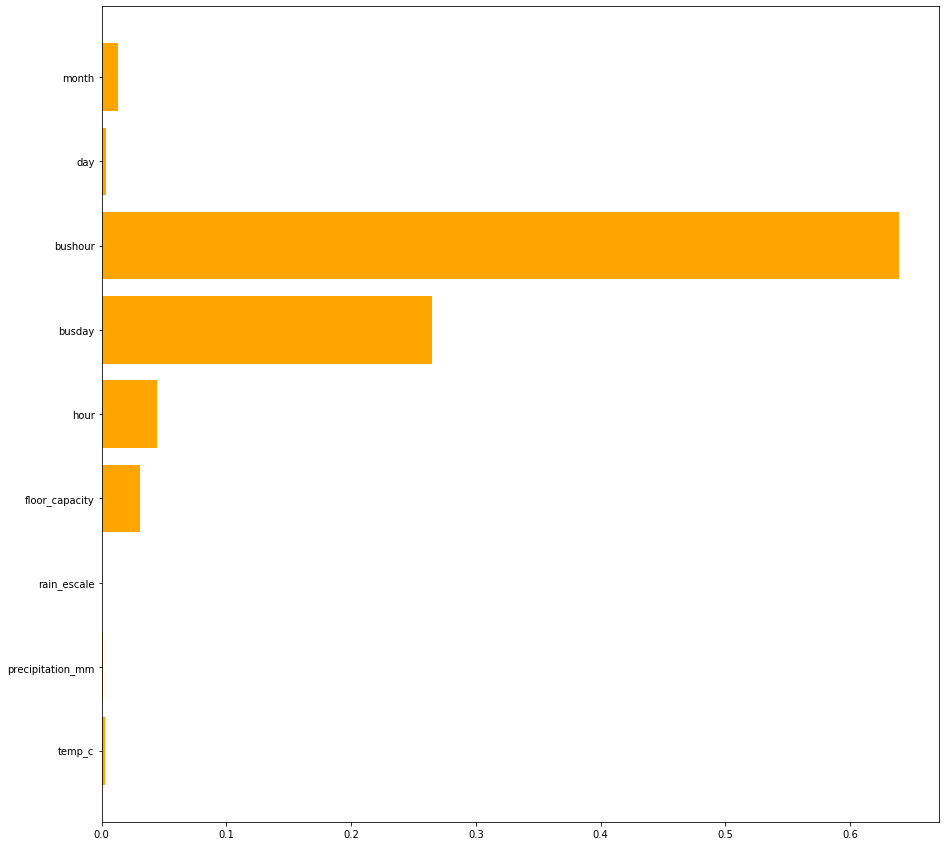

In [13]:
# Plot Feature Importance
plt.rcParams['figure.figsize'] = (15,15)
plt.barh(x_train.columns, xgb.feature_importances_, color='orange')

In [57]:
prediction = cross_val_predict(xgb, x, y, cv=10)

y = np.reshape(y, (-1,1))
prediction = np.reshape(prediction, (-1,1))

print('MAE:', metrics.mean_absolute_error(y, prediction))
print('RMSE:', sqrt(metrics.mean_squared_error(y, prediction)))

MAE: 16.791742750303047
RMSE: 30.695841266316492


In [18]:
df_train['building_floor'].unique()

array(['T100', 'T101', 'T102', 'T103', 'T104', 'T105', 'T106', 'T107',
       'T108', 'T109', 'T110', 'T111', 'T113', 'T114', 'T115', 'T116',
       'T118', 'T119', 'T120', 'T121', 'T122', 'T124', 'T125', 'T126',
       'T127', 'T129', 'T130', 'T131', 'T133', 'T134', 'T135'],
      dtype=object)

In [58]:
df = x
df['attendance'] = y['attendance']
df['prediction'] = prediction
df['date_hour'] = df_train['date_hour']
df['building_floor'] = df_train['building_floor']
df['floor_capacity'] = df_train['floor_capacity']
df['meeting_room_capacity'] = df_train['meeting_room_capacity']
df['meeting_room_number'] = df_train['meeting_room_number']
df['number_of_metro_1'] = df_train['number_of_metro_1']
df['number_of_rer_a'] = df_train['number_of_rer_a']
df['month'] = df_train['month']
df['day'] = df_train['day']

In [59]:
df = df.sort_values(by=['date_hour', 'building_floor'])

In [78]:
dfm = df[(df['month'] == 4) & (df['building_floor'] == 'T101')]
dfa = df[(df['month'] == 4) & (df['building_floor'] == 'T101') & (df['day'] >= 25)]

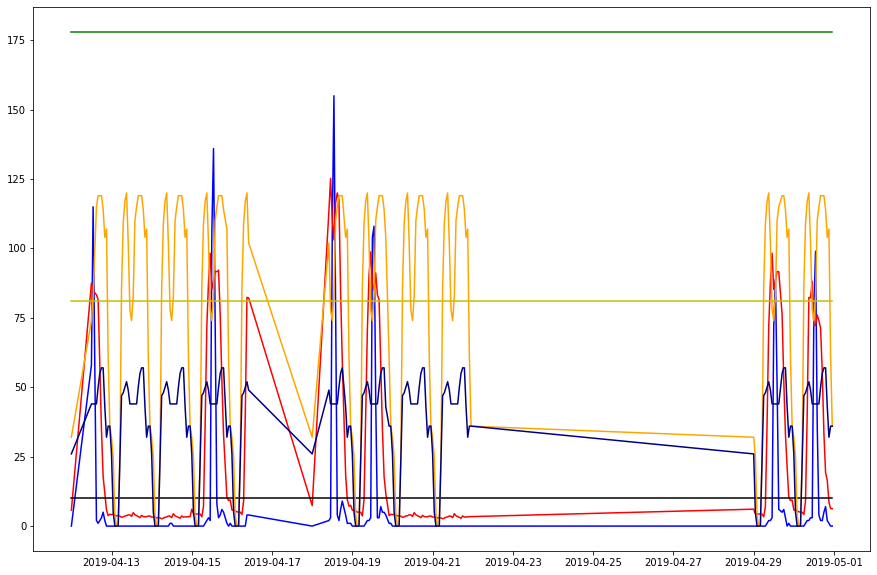

In [79]:
plt.plot(dfm['date_hour'], dfm['attendance'], color='b')
plt.plot(dfm['date_hour'], dfm['prediction'], color='r')
plt.plot(dfm['date_hour'], dfm['floor_capacity'], color='g')
plt.plot(dfm['date_hour'], dfm['meeting_room_capacity'], color='y')
plt.plot(dfm['date_hour'], dfm['meeting_room_number'], color='black')
plt.plot(dfm['date_hour'], dfm['number_of_metro_1'], color='orange')
plt.plot(dfm['date_hour'], dfm['number_of_rer_a'], color='navy')
plt.rcParams['figure.figsize'] = (15,15)
plt.show()

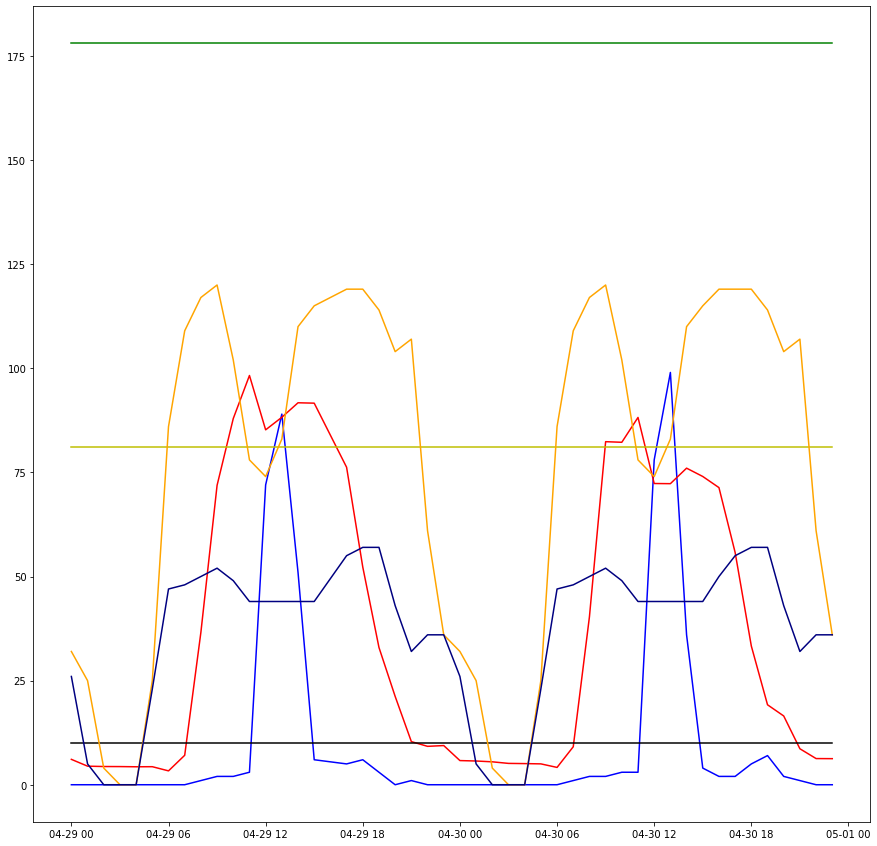

In [80]:
plt.plot(dfa['date_hour'], dfa['attendance'], color='b')
plt.plot(dfa['date_hour'], dfa['prediction'], color='r')
plt.plot(dfa['date_hour'], dfa['floor_capacity'], color='g')
plt.plot(dfa['date_hour'], dfa['meeting_room_capacity'], color='y')
plt.plot(dfa['date_hour'], dfa['meeting_room_number'], color='black')
plt.plot(dfa['date_hour'], dfa['number_of_metro_1'], color='orange')
plt.plot(dfa['date_hour'], dfa['number_of_rer_a'], color='navy')
plt.rcParams['figure.figsize'] = (15,10)
plt.show()

## Cathegorical Boost Regressor

In [56]:
#####  GRID SEARCH
model = CatBoostRegressor()
parameters = {'depth'         : [6,8,10],
              'learning_rate' : [0.1, 0.5, 1],
              'iterations'    : [50, 100, 150]
             }

grid_search_result = model.grid_search(parameters, X=x_train, y=y_train, plot=True)

#grid = GridSearchCV(estimator=model, param_grid = parameters, n_jobs=-1)
#grid.fit(x_train, y_train)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 18.7571310	best: 18.7571310 (0)	total: 707ms	remaining: 18.4s
1:	loss: 12.5672988	best: 12.5672988 (1)	total: 1.31s	remaining: 16.4s
2:	loss: 12.0413085	best: 12.0413085 (2)	total: 2.01s	remaining: 16.1s
3:	loss: 15.5843460	best: 12.0413085 (2)	total: 3.27s	remaining: 18.8s
4:	loss: 10.8590958	best: 10.8590958 (4)	total: 4.13s	remaining: 18.2s
5:	loss: 10.6150016	best: 10.6150016 (5)	total: 5.17s	remaining: 18.1s
6:	loss: 14.0296049	best: 10.6150016 (5)	total: 6.47s	remaining: 18.5s
7:	loss: 10.1316555	best: 10.1316555 (7)	total: 7.8s	remaining: 18.5s
8:	loss: 10.0123517	best: 10.0123517 (8)	total: 9.11s	remaining: 18.2s
9:	loss: 16.5365602	best: 10.0123517 (8)	total: 9.7s	remaining: 16.5s
10:	loss: 10.2669245	best: 10.0123517 (8)	total: 10.4s	remaining: 15.1s
11:	loss: 9.9109629	best: 9.9109629 (11)	total: 11.1s	remaining: 13.9s
12:	loss: 13.2265875	best: 9.9109629 (11)	total: 12.5s	remaining: 13.5s
13:	loss: 9.0855671	best: 9.0855671 (13)	total: 13.8s	remaining: 12.8s
14:	lo

Fit and Predict

In [19]:
model = CatBoostRegressor(iterations=150, depth=10, learning_rate=0.5, loss_function='RMSE',verbose=False)

In [20]:
prediction = cross_val_predict(model, x, y, cv=10)

y = np.reshape(y, (-1,1))
prediction = np.reshape(prediction, (-1,1))

print('MAE:', metrics.mean_absolute_error(y, prediction))
print('RMSE:', sqrt(metrics.mean_squared_error(y, prediction)))

MAE: 18.031602579725995
RMSE: 31.056152523454674


In [58]:
model.fit(x_train, y_train)

In [59]:
# Without Normalization
prediction = model.predict(x_test).astype(int)

<BarContainer object of 8 artists>

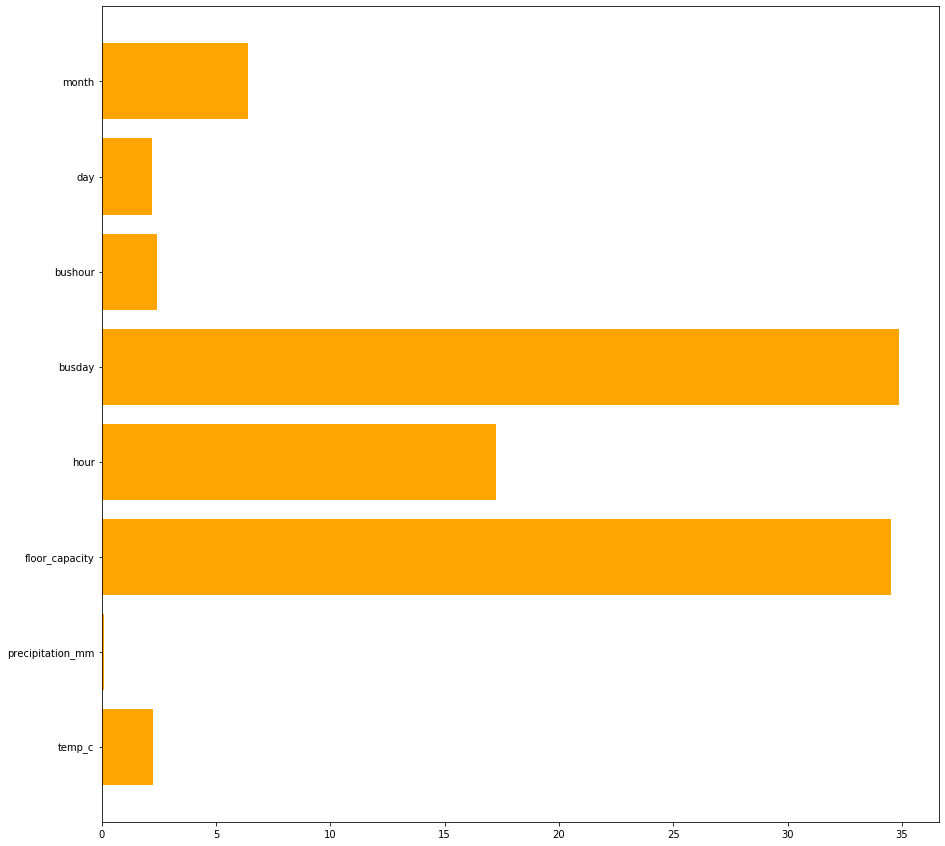

In [60]:
# Plot Feature Importance
plt.rcParams['figure.figsize'] = (15,15)
plt.barh(x_train.columns, model.feature_importances_, color='orange')

Analysing Prediction

In [61]:
from sklearn import metrics
from math import sqrt
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('RMSE:', sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 4.522111896688018
RMSE: 7.821932626151467


In [12]:
x_test['attendance'] = y_test['attendance']
x_test['prediction'] = prediction
x_test['dif'] = x_test['attendance'] - x_test['prediction']

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 5.0000e+00, 1.4000e+01,
        1.8000e+01, 3.3000e+01, 7.7000e+01, 1.1300e+02, 1.5400e+02,
        4.1900e+02, 1.6250e+03, 1.4626e+04, 1.0546e+04, 3.0860e+03,
        9.9200e+02, 6.1200e+02, 3.2900e+02, 3.8500e+02, 3.2000e+02,
        1.7300e+02, 1.8600e+02, 1.9400e+02, 1.3500e+02, 6.8000e+01,
        9.8000e+01, 7.9000e+01, 5.2000e+01, 2.4000e+01, 2.9000e+01,
        3.0000e+01, 1.2000e+01, 1.5000e+01, 1.8000e+01, 5.0000e+00,
        7.0000e+00, 4.0000e+00, 4.0000e+00, 2.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-6.70000000e+01, -6.32714286e+01, -5.9

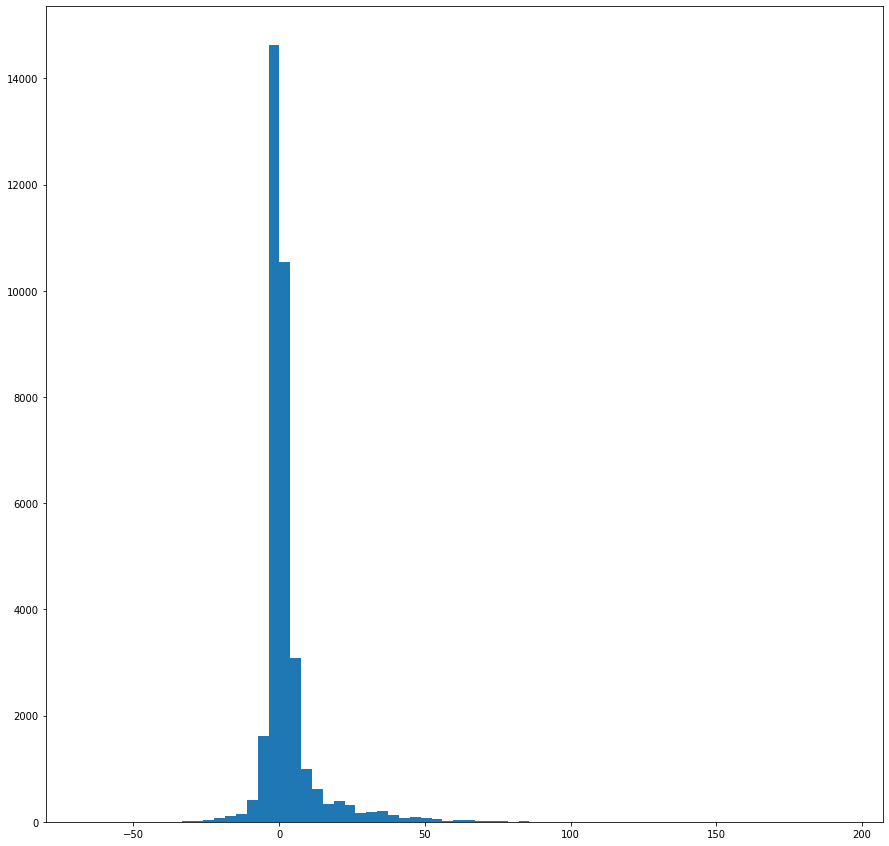

In [16]:
plt.hist(x_test['dif'], bins=70)

{'whiskers': [<matplotlib.lines.Line2D at 0x171035dffc8>,
 'caps': [<matplotlib.lines.Line2D at 0x171035e3a48>,
 'boxes': [<matplotlib.lines.Line2D at 0x171035df888>],
 'medians': [<matplotlib.lines.Line2D at 0x171035eaf88>],
 'fliers': [<matplotlib.lines.Line2D at 0x171035ee8c8>],
 'means': []}

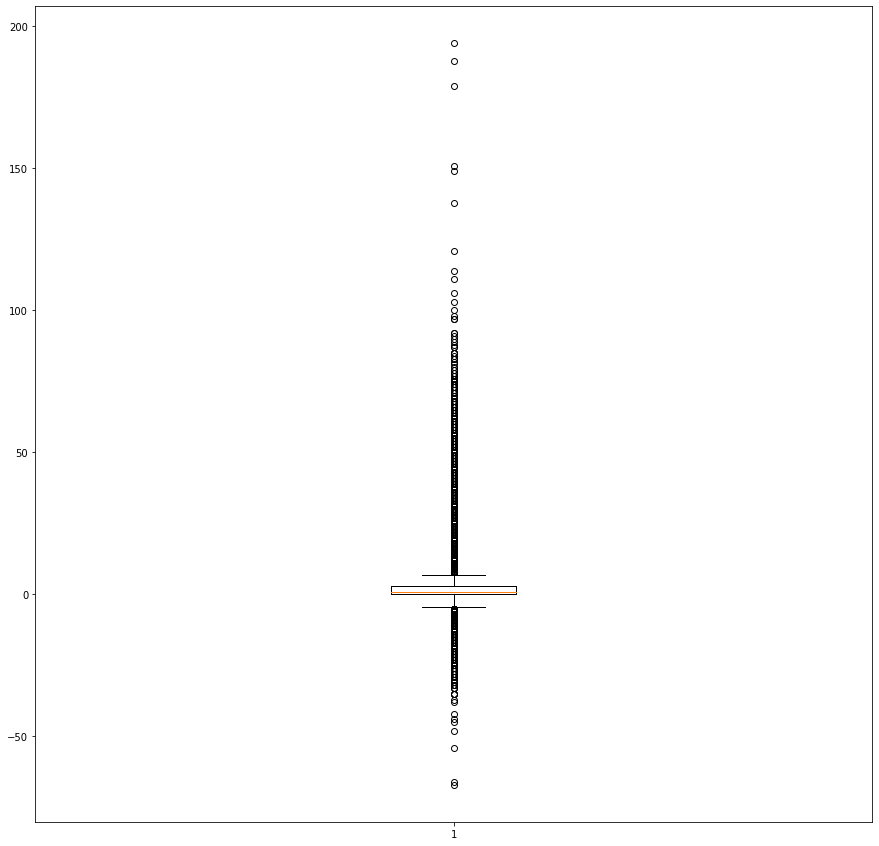

In [17]:
plt.boxplot(x=x_test['dif'])

In [14]:
x_test[x_test['dif'] >= 50]

temp_c  precipitation_mm  sunshine_duration_h  floor_capacity  hour  \
157458     4.2              0.00                  0.0           193.0    17   
34544     32.3              0.00                  0.7           193.0    11   
52997     23.5              0.00                  0.8           236.0     7   
118935    10.5              0.00                  0.5           245.0    15   
27966     12.6              7.27                  0.0           221.0    18   
...        ...               ...                  ...             ...   ...   
157471     4.2              0.00                  0.0           219.0    17   
162500     8.0              0.50                  0.0           170.0    11   
118189    12.1              0.76                  0.0           267.0    15   
169401     8.9              0.00                  0.0           267.0    18   
159555     4.7              0.00                  0.6           170.0    12   

        busday  number_of_metro_1  number_of_rer_a  day  month  attendance  \
157458       0              119.0             55.0   20      1       178.0   
34544        0               78.0             44.0   18      6       154.0   
52997        1              109.0             48.0   20      7        66.0   
118935       0              115.0             44.0    7     11       184.0   
27966        0              119.0             57.0    5      6       177.0   
...        ...                ...              ...  ...    ...         ...   
157471       0              119.0             55.0   20      1       178.0   
162500       0               78.0             44.0   27      1       151.0   
118189       0              115.0             44.0    6     11       213.0   
169401       0              119.0             57.0    5      2       172.0   
159555       0               74.0             44.0   23      1       142.0   

        prediction   dif  
157458         110  68.0  
34544           99  55.0  
52997           16  50.0  
118935         127  57.0  
27966          102  75.0  
...            ...   ...  
157471         122  56.0  
162500          99  52.0  
118189         150  63.0  
169401          82  90.0  
159555          91  51.0  

[279 rows x 13 columns]

# ************* MODEL BY FLOOR - With XGBoost*************

I tryed split the floors and fit a model for floor, but it was not more predictive

In [161]:
floors = df_train['fact_building_floor'].unique()

In [162]:
# Separate Business Day

df_not_busday = df_train[df_train['busday'] == 1]
df_busday = df_train[df_train['busday'] == 0]



In [163]:
result = pd.DataFrame()

for f in floors:
    
    df_f = df_busday[df_busday['fact_building_floor'] == f]
    df_n = df_not_busday[df_not_busday['fact_building_floor'] == f]
    
    print(df_f.head(1)['building_floor'])    
    
    x = df_f[['meeting_room_capacity', 'number_of_metro_1', 'number_of_rer_a', 'floor_capacity', 'hour', 'month', 'weekday', 'precipitation_mm']]

    y = df_f[['attendance']]  
    
    xgb = XGBRegressor(colsample_bytree=0.9, gamma=0.3, max_depth=10, min_chils_weight=4, subsample=1, nthread=-1) 
    
    prediction = cross_val_predict(xgb, x, y, cv=10)

    #y = np.reshape(y, (-1,1))
    #prediction = np.reshape(prediction, (-1,1))
    
    res = pd.DataFrame()
    res['date_hour'] = df_f['date_hour']
    res['building_floor'] = df_f['building_floor']
    res['prediction'] = prediction
    res['test'] = y['attendance'].values
    
    res_not = pd.DataFrame()
    res_not['date_hour'] = df_n['date_hour']
    res_not['building_floor'] = df_n['building_floor']
    res_not['prediction'] = 0
    res_not['test'] = df_n['attendance']
            
    df_f['prediction'] = prediction
    df_n['prediction'] = 0
    df_f['prediction'] = df_f['prediction'].apply(lambda x: x if x >= 0 else 0)
    
    res = res.append(res_not)
    
    print('MAE:', metrics.mean_absolute_error(res['test'], res['prediction']))
    print('RMSE:', sqrt(metrics.mean_squared_error(res['test'], res['prediction'])))
    
    result = result.append(res)
    
    
    

0    T100
Name: building_floor, dtype: object
MAE: 13.243648014081092
RMSE: 25.397395355558892
1    T101
Name: building_floor, dtype: object
MAE: 6.8921038849578595
RMSE: 24.18775974815632
2    T102
Name: building_floor, dtype: object
MAE: 15.533700482660402
RMSE: 51.6681359432293
3    T103
Name: building_floor, dtype: object
MAE: 13.49129204079265
RMSE: 23.15354498430072
4    T104
Name: building_floor, dtype: object
MAE: 23.39570400989416
RMSE: 32.91961632770096
5    T105
Name: building_floor, dtype: object
MAE: 19.617901308927337
RMSE: 26.04813841685489
6    T106
Name: building_floor, dtype: object
MAE: 19.854930922746572
RMSE: 27.383748192566266
7    T107
Name: building_floor, dtype: object
MAE: 20.529462737045932
RMSE: 29.504086028319517
8    T108
Name: building_floor, dtype: object
MAE: 30.431259827538362
RMSE: 43.571804410908975
9    T109
Name: building_floor, dtype: object
MAE: 9.597569598886755
RMSE: 20.160159322675227
1932    T110
Name: building_floor, dtype: object
MAE: 11.88

In [58]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45132 entries, 0 to 1528
Data columns (total 2 columns):
prediction    45132 non-null int32
test          45132 non-null float64
dtypes: float64(1), int32(1)
memory usage: 881.5 KB


In [164]:
from sklearn import metrics
from math import sqrt
print('MAE:', metrics.mean_absolute_error(result['test'], result['prediction']))
print('RMSE:', sqrt(metrics.mean_squared_error(result['test'], result['prediction'])))

MAE: 12.289092613955106
RMSE: 24.8310898065686


In [144]:
df = df_train.merge(result, on=['date_hour', 'building_floor'], how='left')


In [145]:

df = df.sort_values(by=['date_hour', 'building_floor'])

In [130]:
dfm = df[(df['month'] == 4) & (df['building_floor'] == 'T135')]
dfa = df[(df['month'] == 4) & (df['building_floor'] == 'T135') & (df['day'] >= 15)]

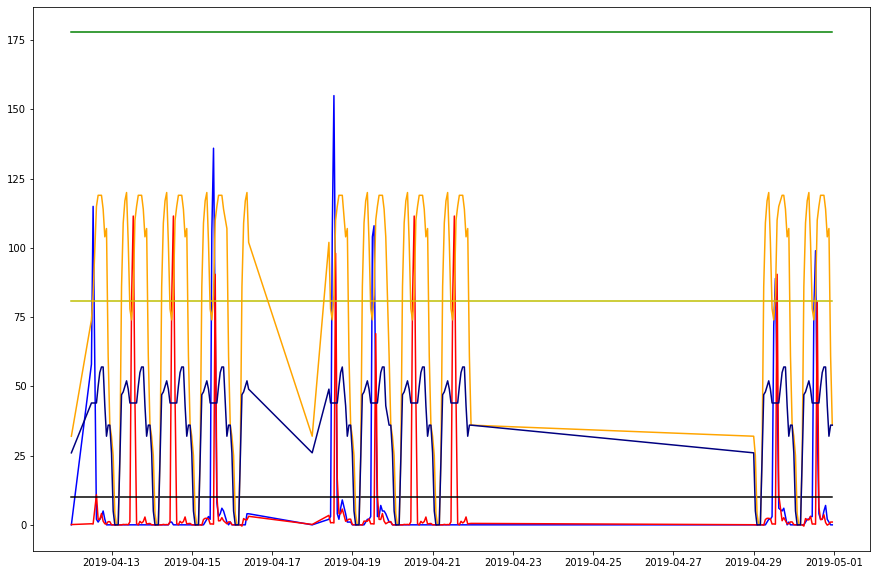

In [115]:
plt.plot(dfm['date_hour'], dfm['attendance'], color='b')
plt.plot(dfm['date_hour'], dfm['prediction'], color='r')
plt.plot(dfm['date_hour'], dfm['floor_capacity'], color='g')
plt.plot(dfm['date_hour'], dfm['meeting_room_capacity'], color='y')
plt.plot(dfm['date_hour'], dfm['meeting_room_number'], color='black')
plt.plot(dfm['date_hour'], dfm['number_of_metro_1'], color='orange')
plt.plot(dfm['date_hour'], dfm['number_of_rer_a'], color='navy')
plt.rcParams['figure.figsize'] = (15,10)
plt.show()

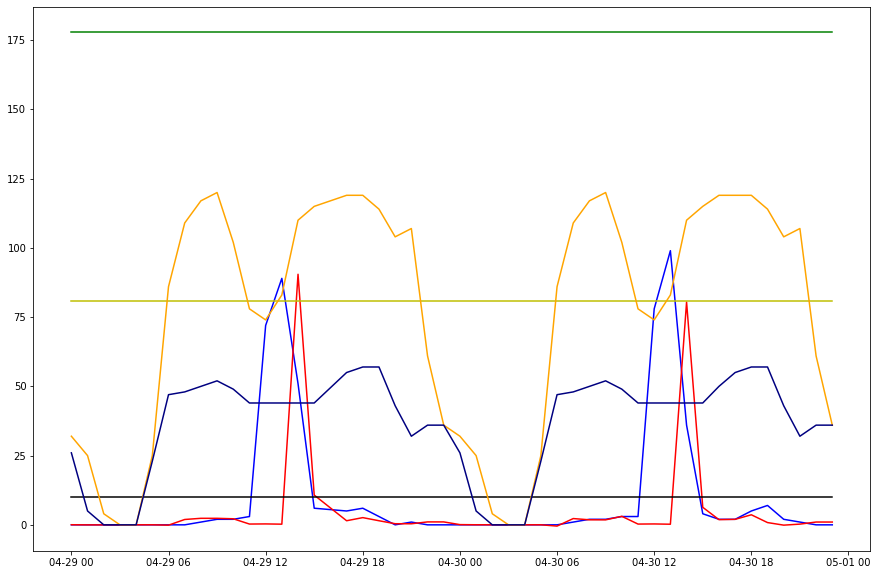

In [116]:
plt.plot(dfa['date_hour'], dfa['attendance'], color='b')
plt.plot(dfa['date_hour'], dfa['prediction'], color='r')
plt.plot(dfa['date_hour'], dfa['floor_capacity'], color='g')
plt.plot(dfa['date_hour'], dfa['meeting_room_capacity'], color='y')
plt.plot(dfa['date_hour'], dfa['meeting_room_number'], color='black')
plt.plot(dfa['date_hour'], dfa['number_of_metro_1'], color='orange')
plt.plot(dfa['date_hour'], dfa['number_of_rer_a'], color='navy')
plt.rcParams['figure.figsize'] = (15,10)
plt.show()

In [156]:
dff = df[(df['building_floor'] == 'T133')]
dff['month_str'] = dff['month'].apply(lambda x: '{:02d}'.format(x))
dff['yearmonth'] = dff['year'].astype(str) + dff['month_str']

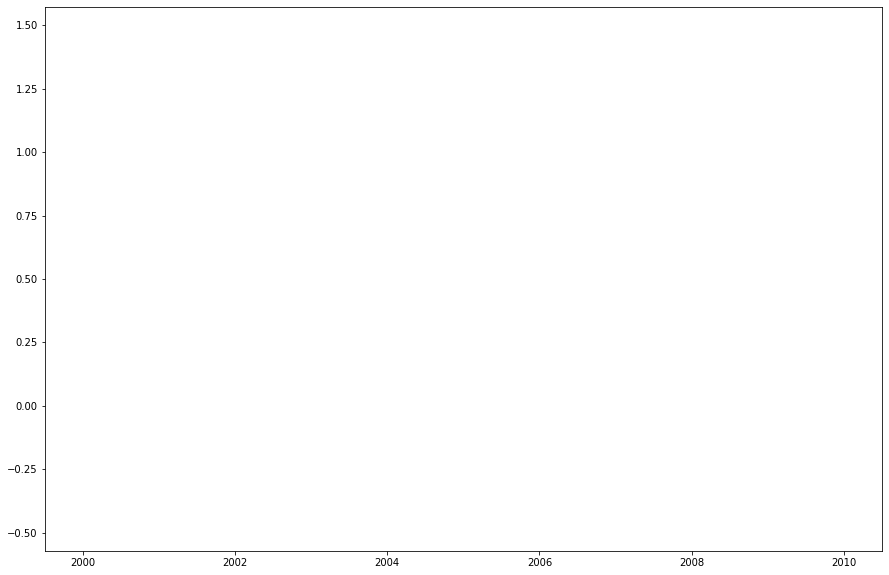

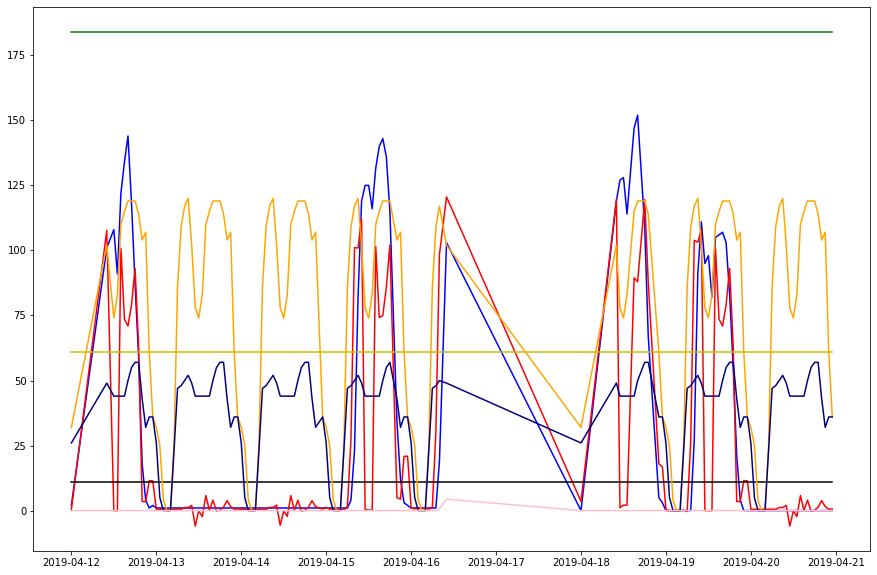

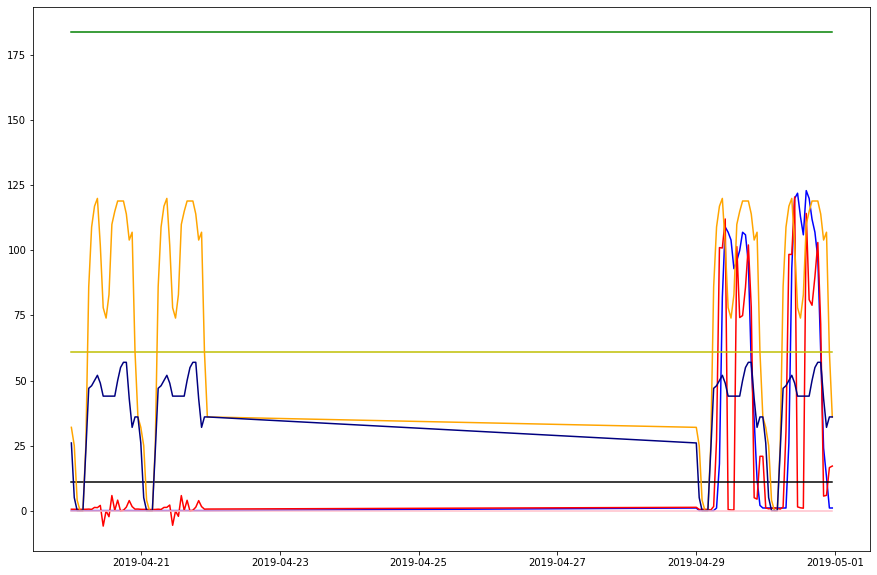

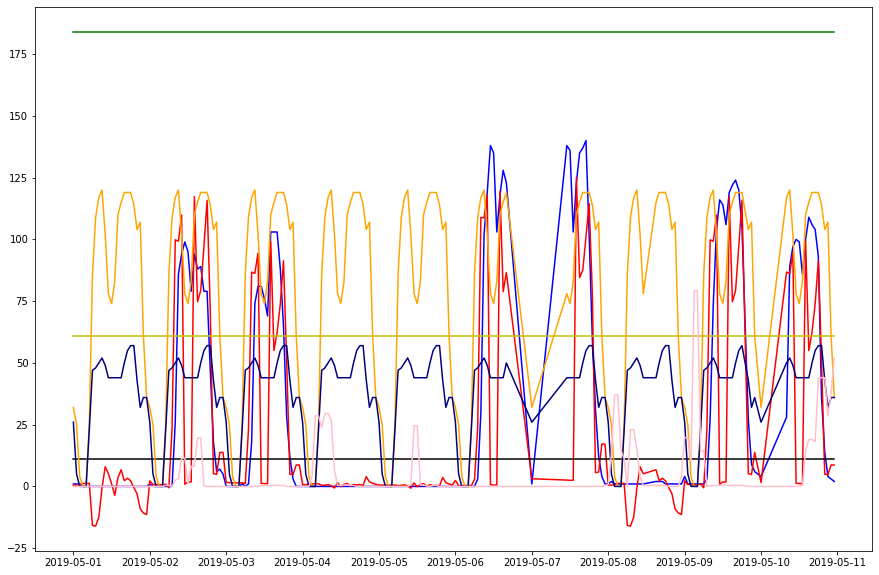

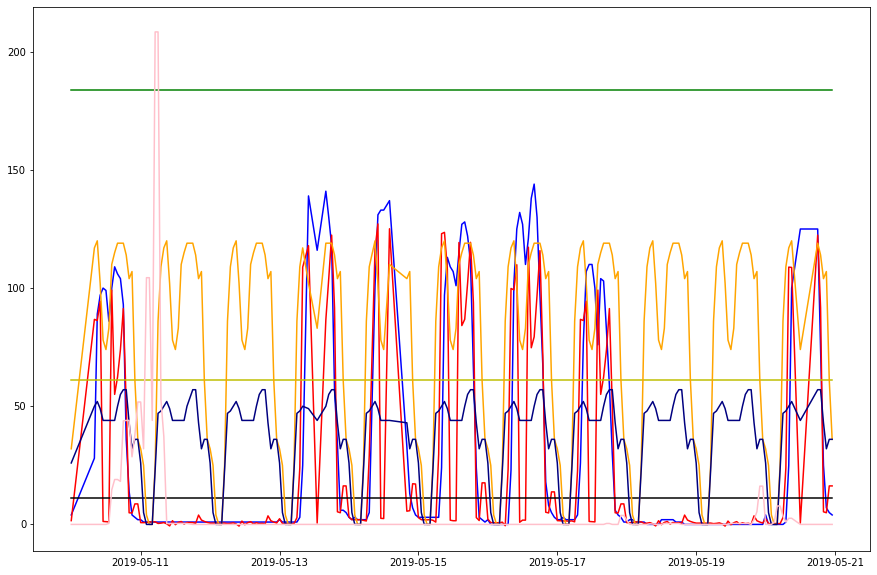

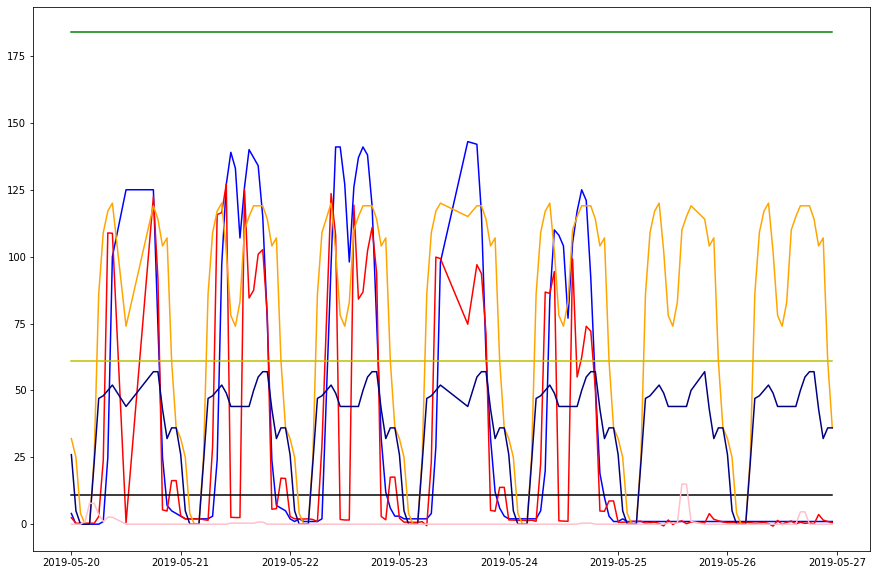

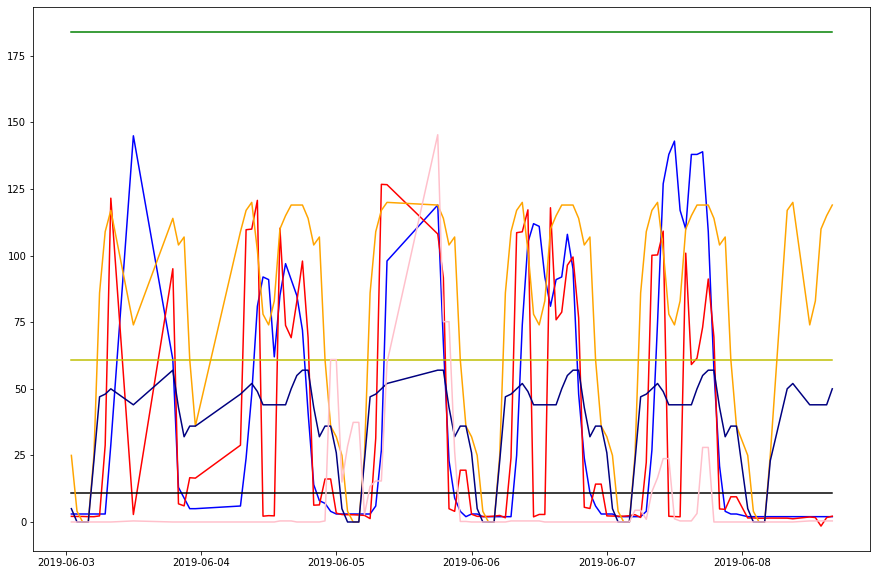

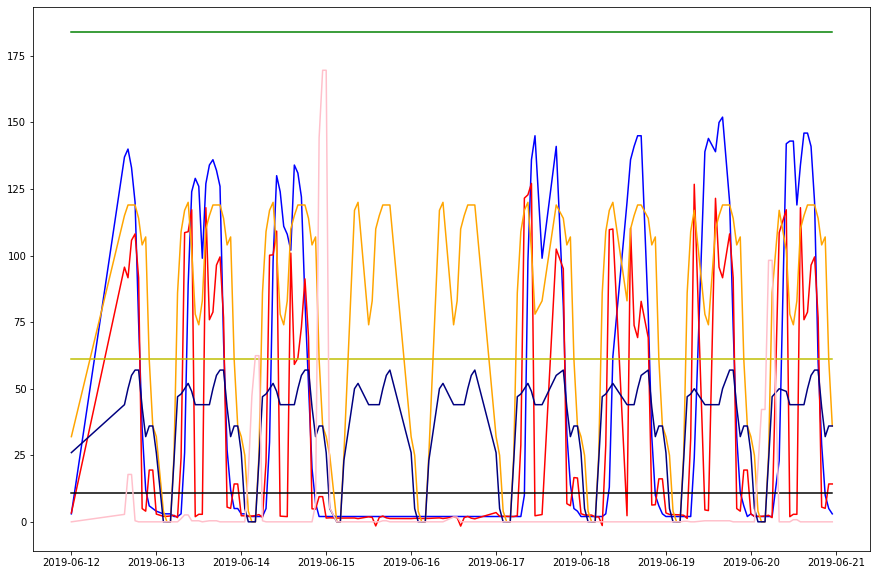

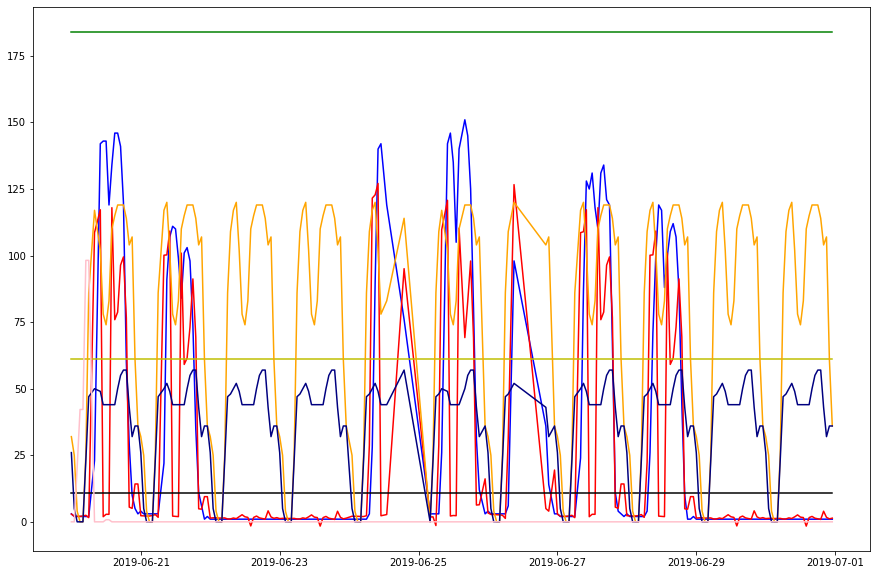

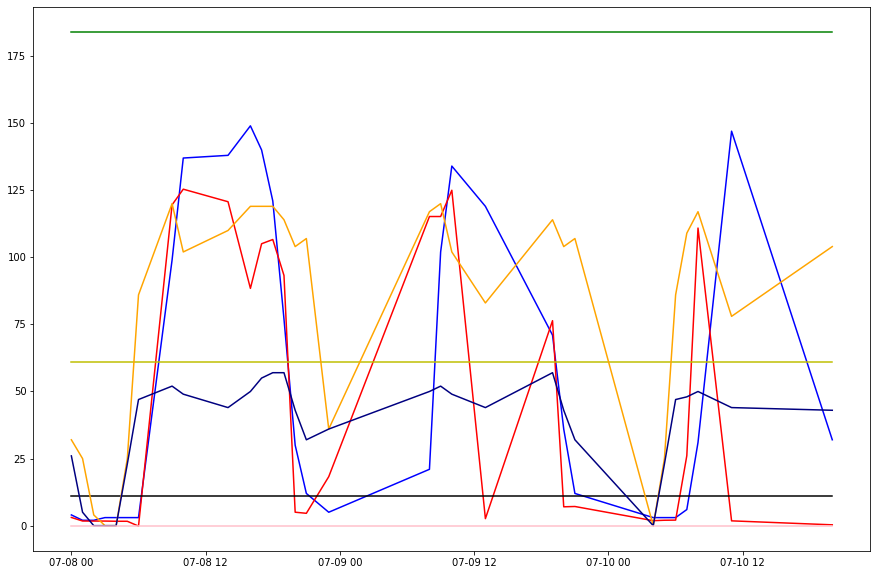

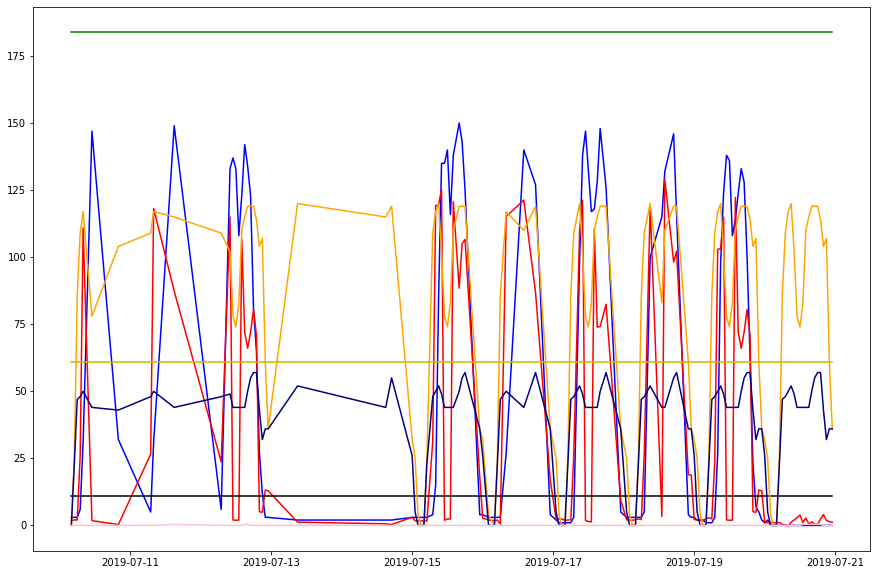

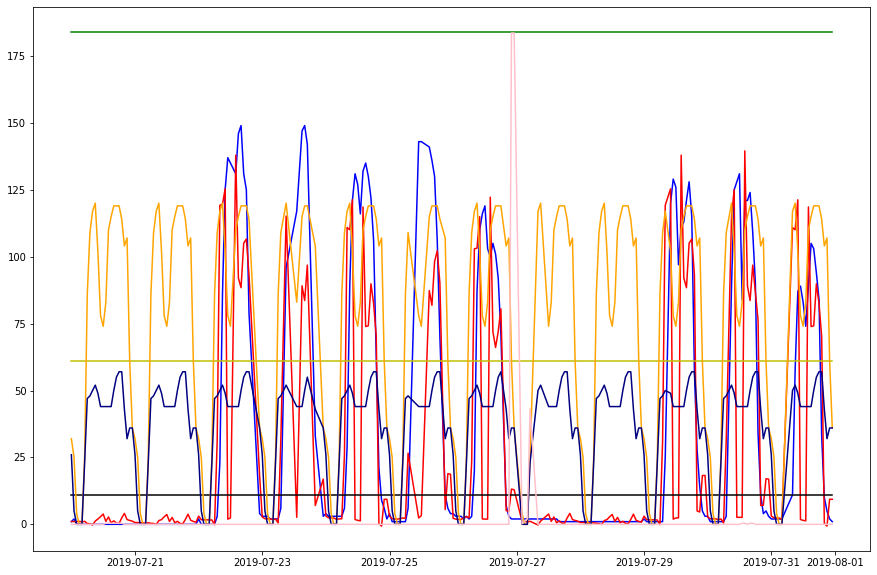

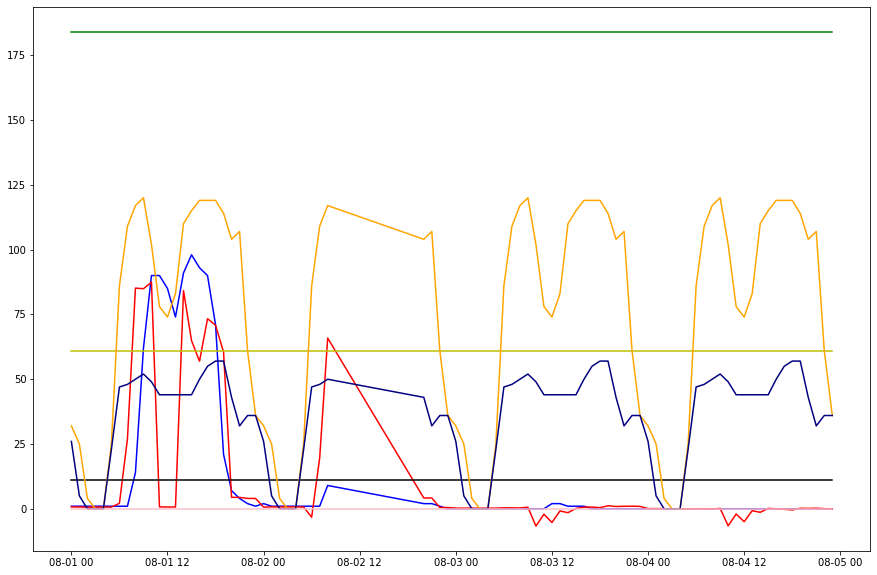

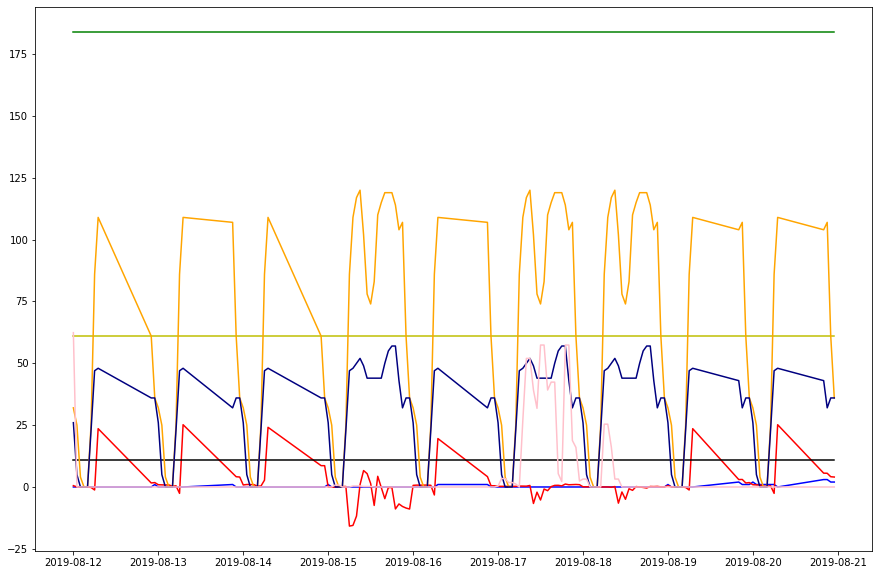

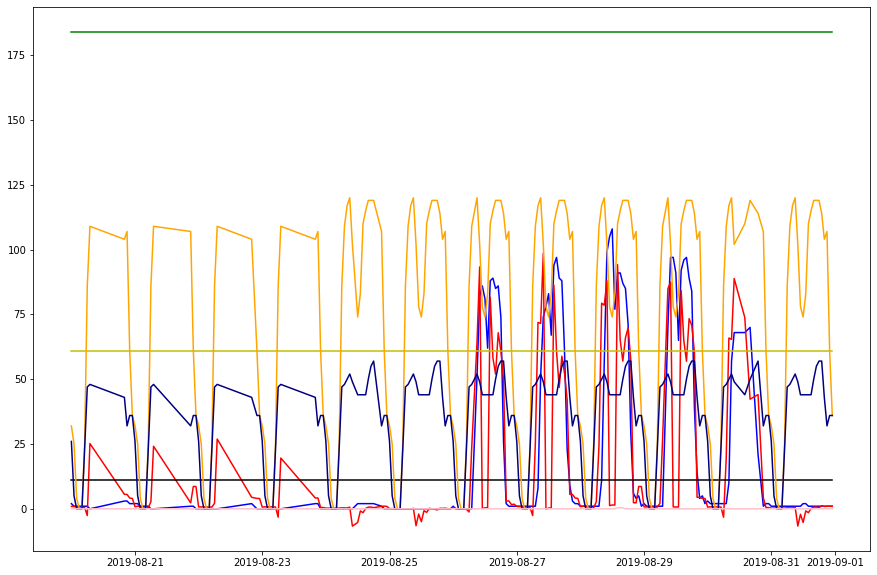

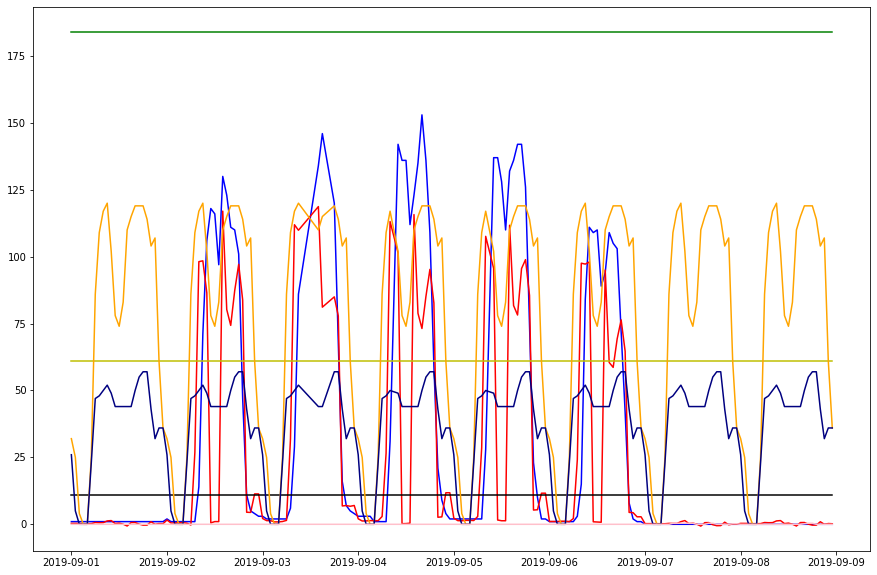

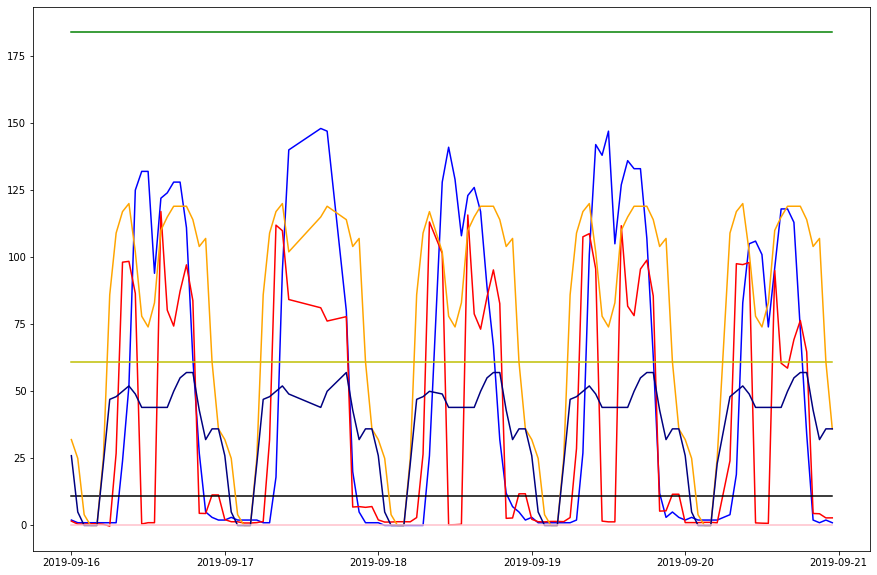

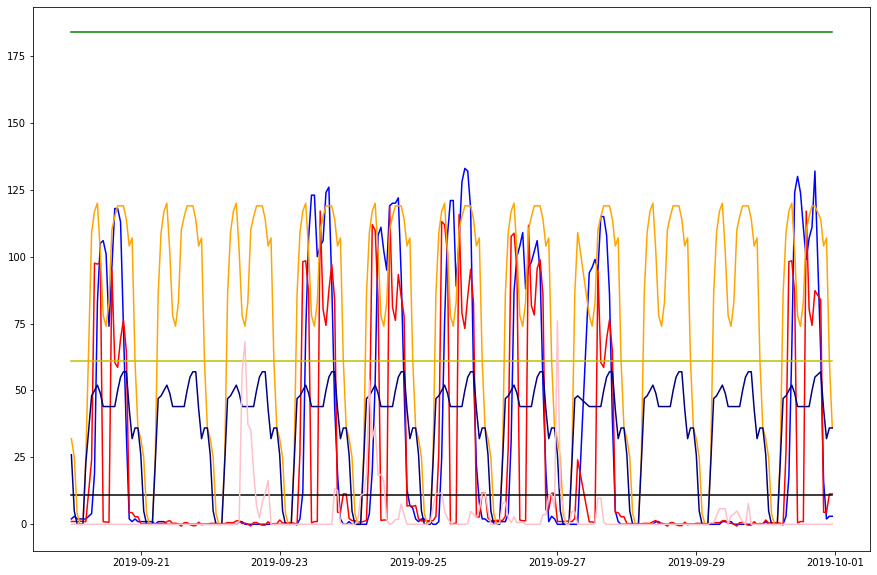

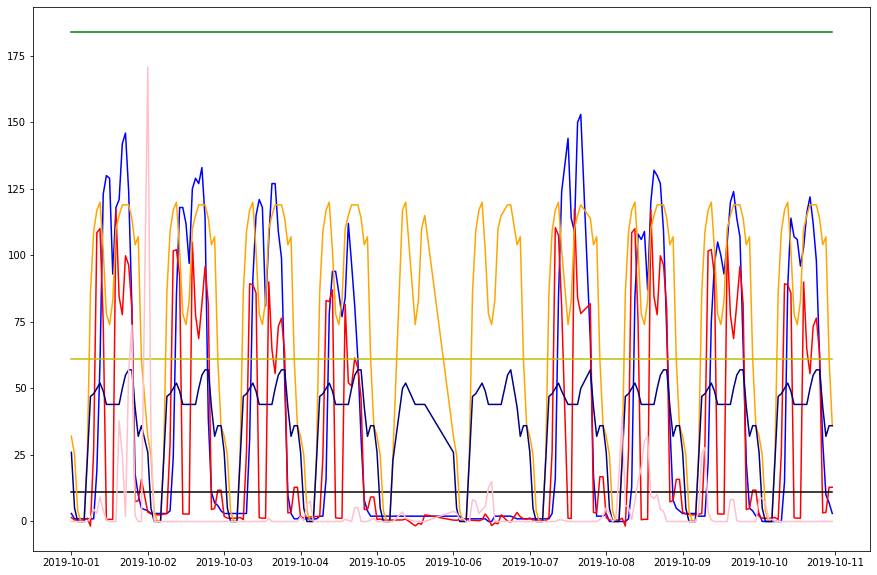

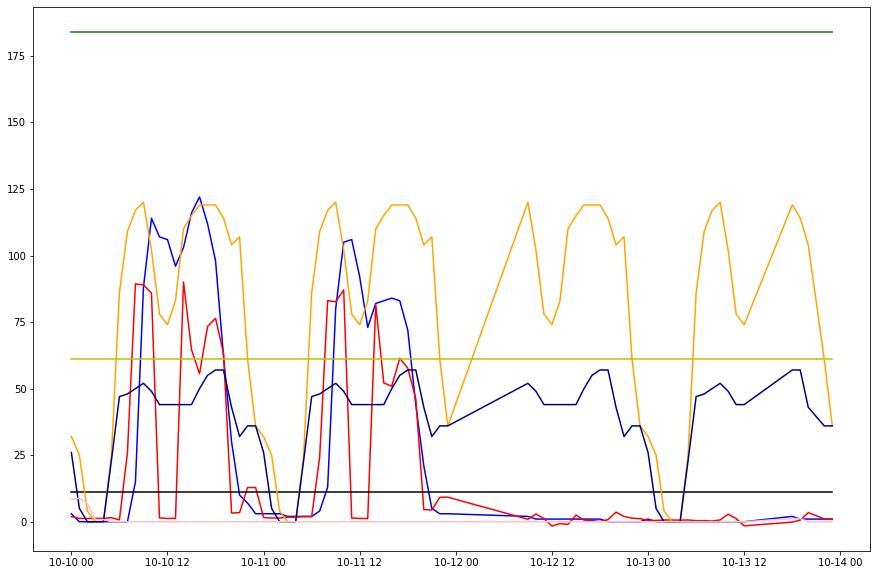

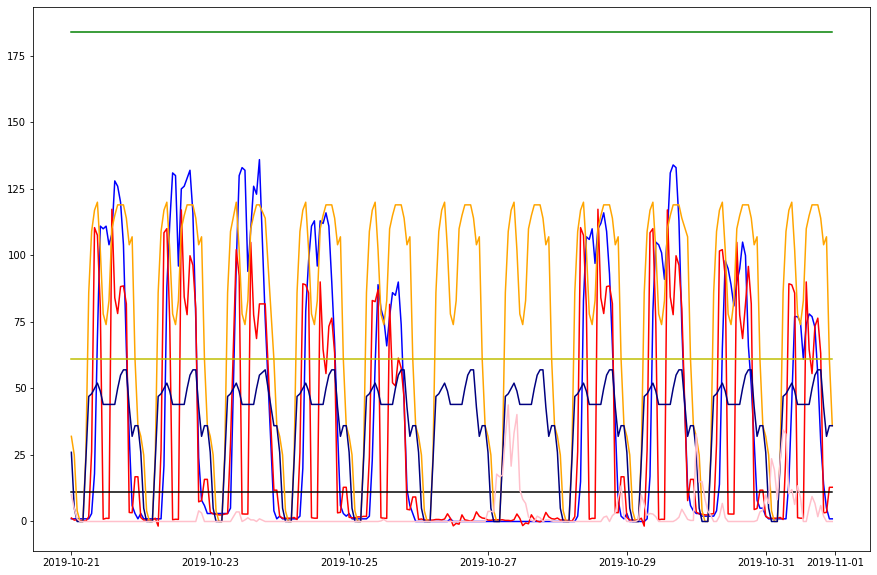

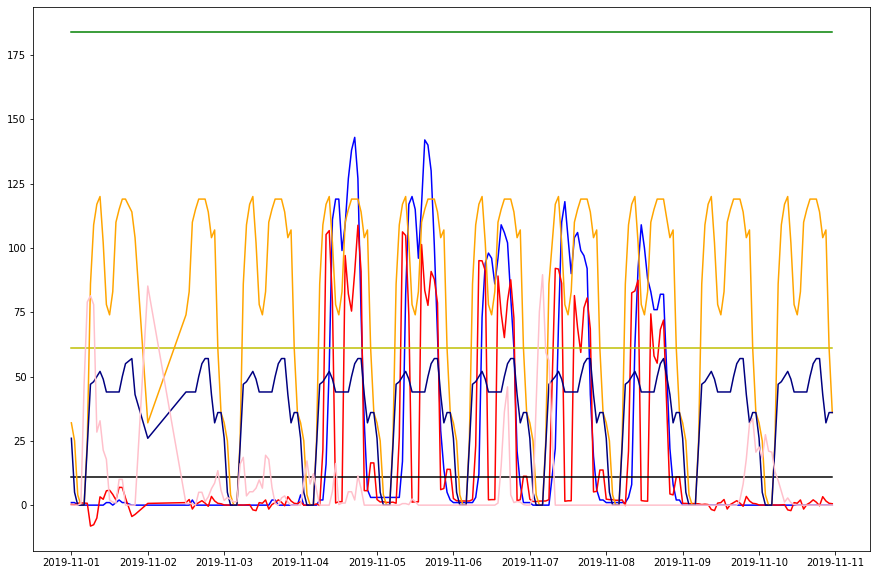

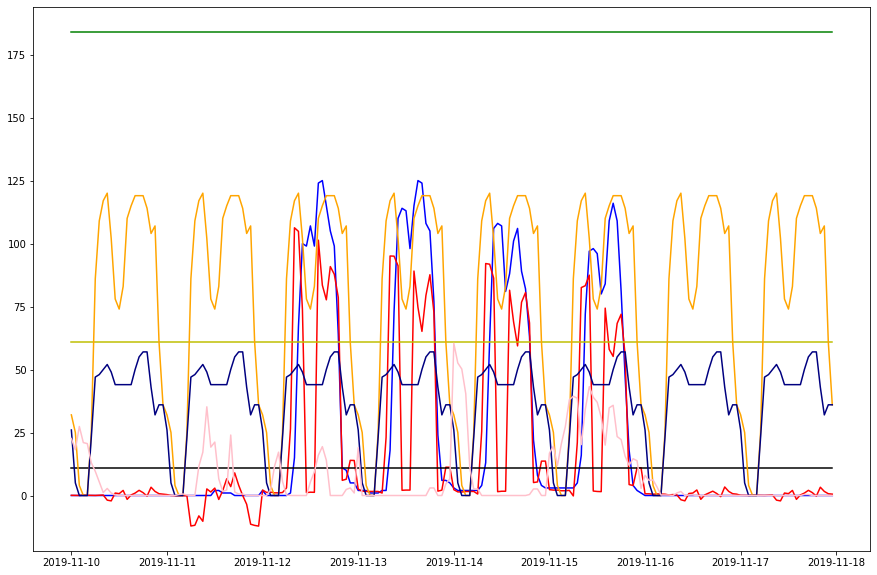

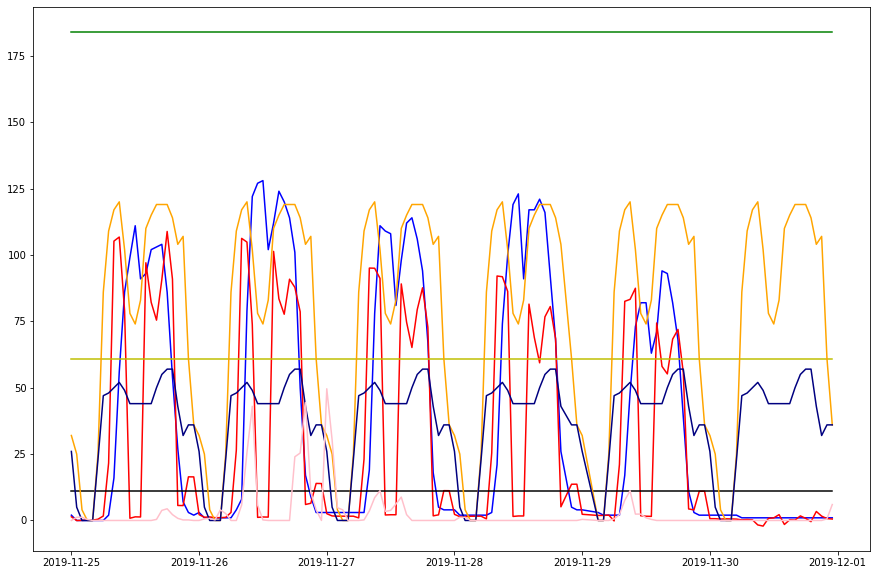

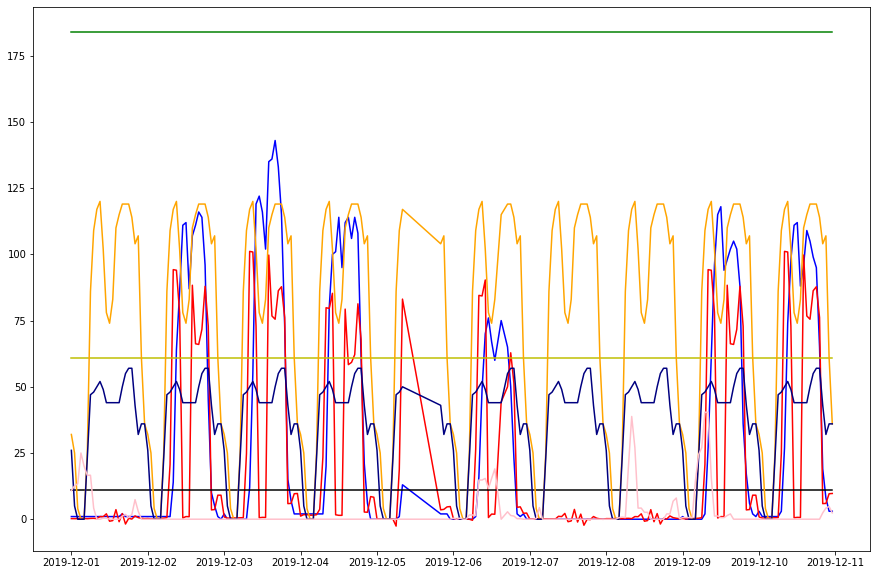

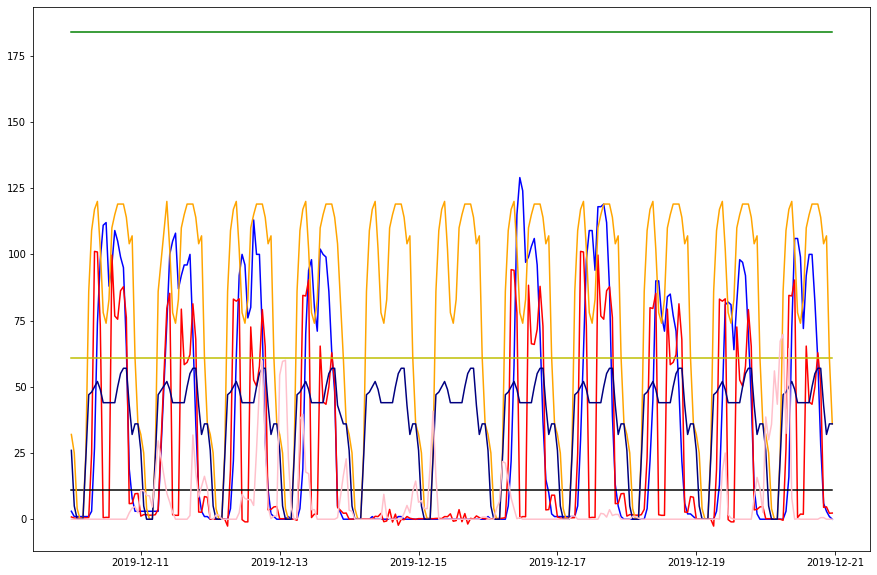

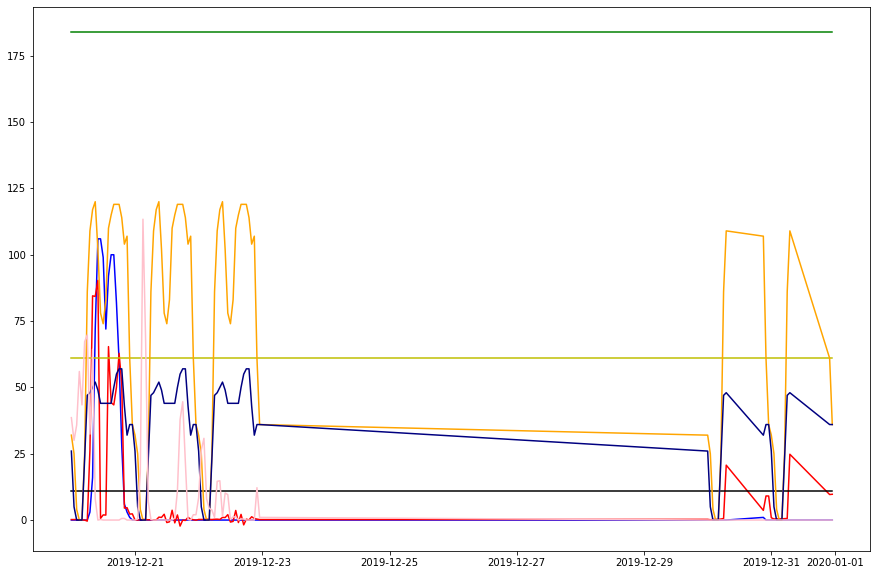

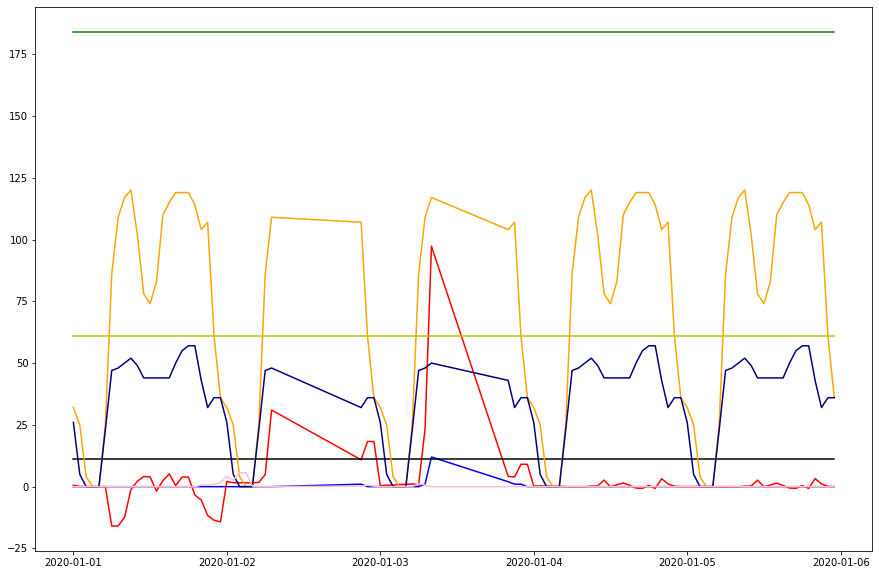

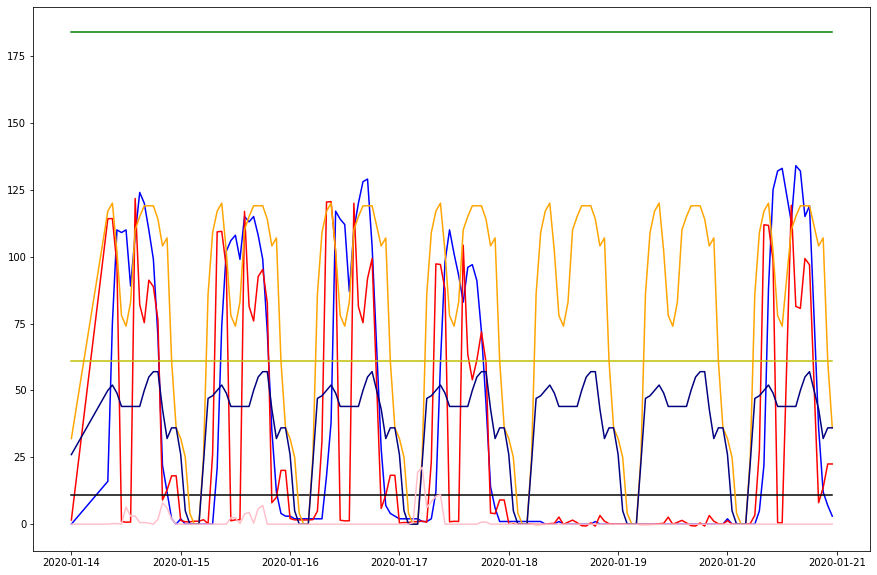

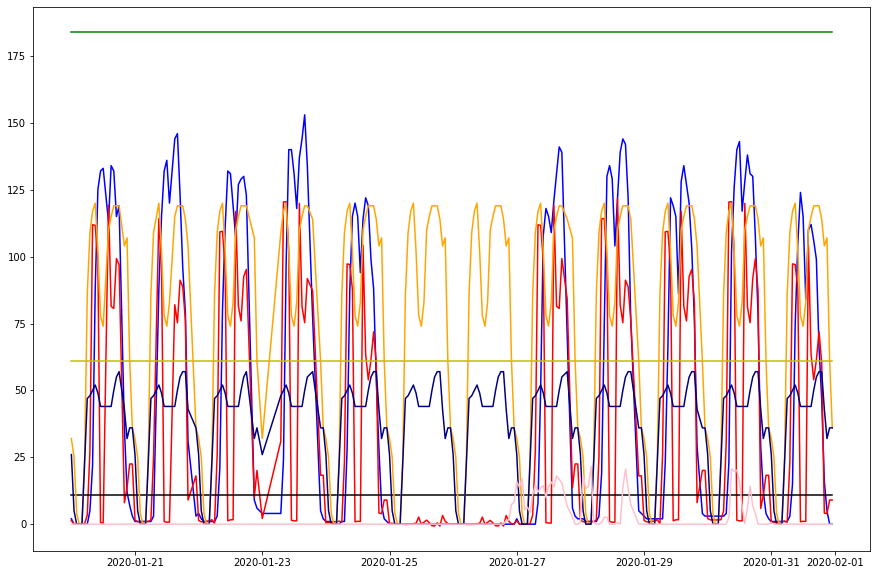

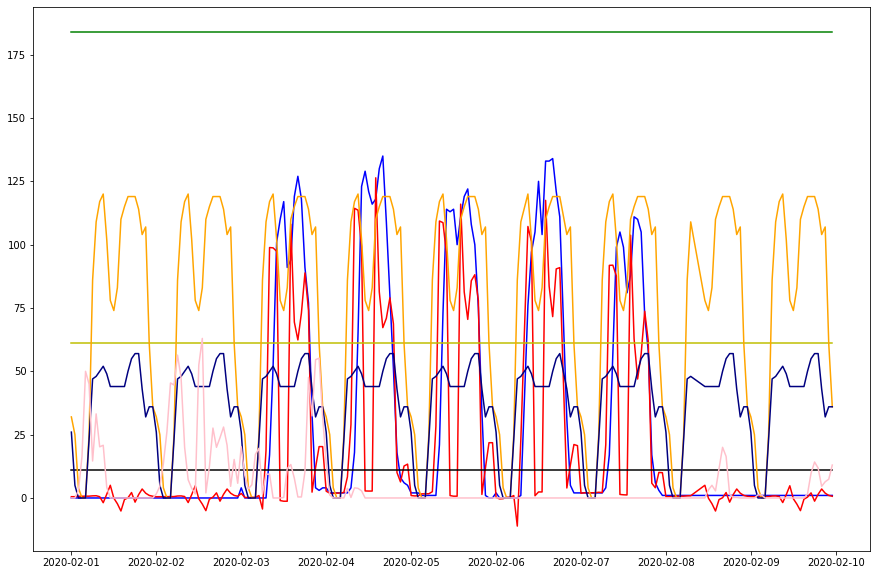

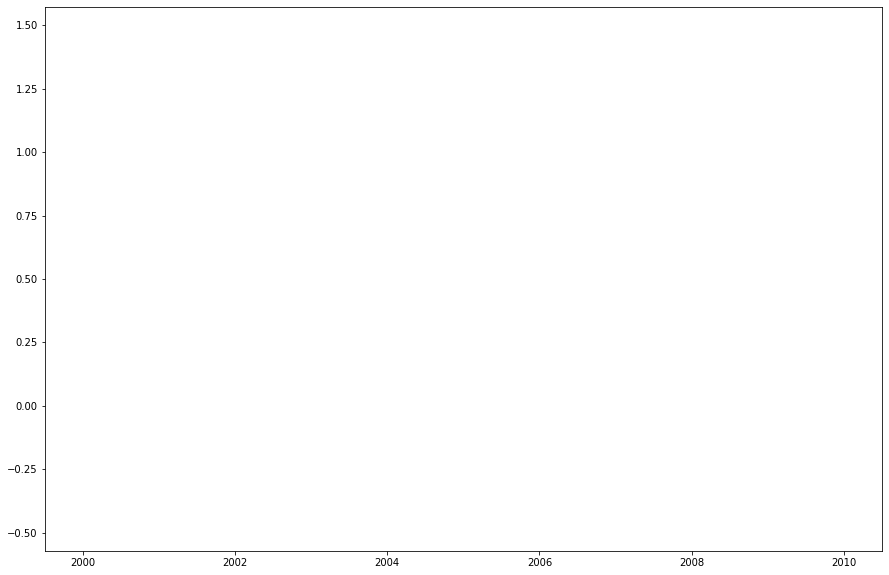

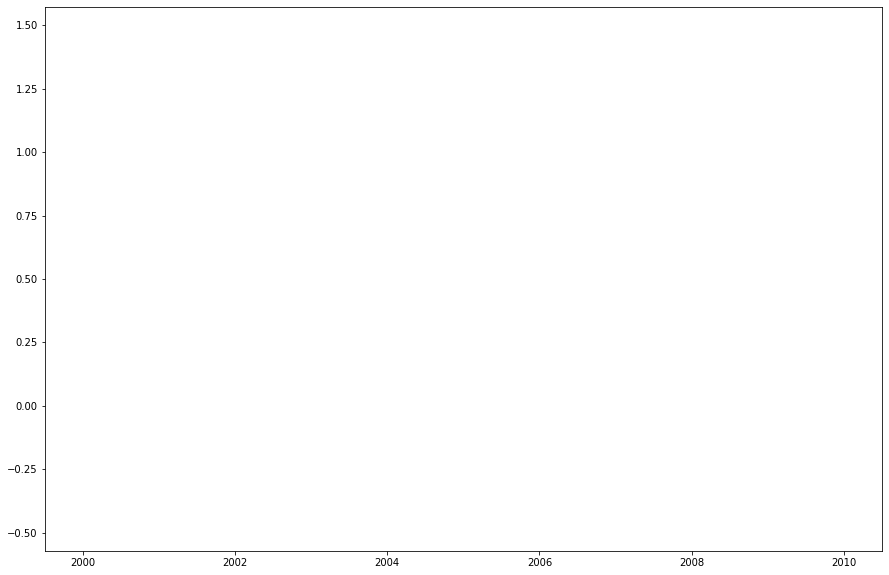

In [157]:
ym = dff['yearmonth'].unique()
pdf = PdfPages('curvasT133.pdf')
dff['precipitation'] = dff['precipitation_mm'] * 20
for m in ym:
    i = 0
    f = 10
    dfym = dff[dff['yearmonth'] == m]
    
    while(f <= 32):
        df1 = dfym[(dfym['day'] >= i) & (dfym['day'] <= f)]
        figure = plt.figure()
        plt.plot(df1['date_hour'], df1['attendance'], color='b')
        plt.plot(df1['date_hour'], df1['prediction'], color='r')
        plt.plot(df1['date_hour'], df1['floor_capacity'], color='g')
        plt.plot(df1['date_hour'], df1['meeting_room_capacity'], color='y')
        plt.plot(df1['date_hour'], df1['meeting_room_number'], color='black')
        plt.plot(df1['date_hour'], df1['number_of_metro_1'], color='orange')
        plt.plot(df1['date_hour'], df1['number_of_rer_a'], color='navy')
        plt.plot(df1['date_hour'], df1['precipitation'], color='pink')
        plt.rcParams['figure.figsize'] = (15,10)
        plt.show()
        
        i = f
        f = f + 10
        if f == 30:
            f = 32
        
        pdf.savefig(figure)

pdf.close()
    
    